# SC Cosmetics 

## Import Libaries

In [2]:
#!pip install pyathena
#!pip install imbalanced-learn
#!pip install -q smclarify==0.1

import boto3
import sagemaker

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyathena import connect
from imblearn.over_sampling import SMOTE

from smclarify.bias import report
from typing import Dict
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format='retina'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Copy Data from S3
https://sc-cosmetics-data.s3.amazonaws.com/chemicals-in-cosmetics/cosmetic_chemicals.csv

https://sc-cosmetics-data.s3.amazonaws.com/cosmetic-ingedients-ranking-pricing/cosmetics.csv

https://sc-cosmetics-data.s3.amazonaws.com/customer-propensity-to-purchase/customer.csv

In [3]:
# define the S3 bucket, role, and region
sess = sagemaker.Session()
bucket = "sc-cosmetics-data"  
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# define S3 paths for the source (public) and destination (private) locations
s3_public_path_chemicals = "s3://sc-cosmetics-data/chemicals-in-cosmetics"
s3_public_path_cosmetics = "s3://sc-cosmetics-data/cosmetic-ingredients-ranking-pricing"
s3_public_path_customer = "s3://sc-cosmetics-data/customer-propensity-to-purchase"
s3_private_path = f"s3://{bucket}/"  
s3_private_path_chemicals = f"s3://{bucket}/chemicals-in-cosmetics"
s3_private_path_cosmetics = f"s3://{bucket}/cosmetic-ingredients-ranking-pricing"
s3_private_path_customer = f"s3://{bucket}/customer-propensity-to-purchase"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
# copy data from the public S3 buckets to our private S3 buckets
!aws s3 cp --recursive $s3_public_path_chemicals/ $s3_private_path_chemicals/
!aws s3 cp --recursive $s3_public_path_cosmetics/ $s3_private_path_cosmetics/
!aws s3 cp --recursive $s3_public_path_customer/ $s3_private_path_customer/

copy: s3://sc-cosmetics-data/chemicals-in-cosmetics/cosmetic_chemicals.csv to s3://sc-cosmetics-data/chemicals-in-cosmetics/cosmetic_chemicals.csv
copy: s3://sc-cosmetics-data/cosmetic-ingredients-ranking-pricing/cosmetics.csv to s3://sc-cosmetics-data/cosmetic-ingredients-ranking-pricing/cosmetics.csv
copy: s3://sc-cosmetics-data/customer-propensity-to-purchase/customer.csv to s3://sc-cosmetics-data/customer-propensity-to-purchase/customer.csv


In [5]:
# list files in private S3 bucket
print("Files in private S3 bucket - Chemicals:")
!aws s3 ls $s3_private_path_chemicals/

print("\nFiles in private S3 bucket - Cosmetics:")
!aws s3 ls $s3_private_path_cosmetics/

print("\nFiles in private S3 bucket - Customer:")
!aws s3 ls $s3_private_path_customer/

Files in private S3 bucket - Chemicals:
2024-03-18 01:48:28   23962866 cosmetic_chemicals.csv

Files in private S3 bucket - Cosmetics:
2024-03-18 01:48:29    1157561 cosmetics.csv

Files in private S3 bucket - Customer:
2024-03-18 01:48:30   35077633 customer.csv


In [6]:
# read files into pd df
chemicals_df = pd.read_csv(s3_private_path_chemicals + "/cosmetic_chemicals.csv")
cosmetics_df = pd.read_csv(s3_private_path_cosmetics + "/cosmetics.csv")
customer_df = pd.read_csv(s3_private_path_customer + "/customer.csv")

## Data Exploration

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
chemicals_df.head()

,ProductName,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,SubCategory,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalCount,Discontinued,ChemicalRemoved,brand_id
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,Lip Color - Lipsticks Liners and Pencils,6,Titanium dioxide,2009-06-17,2013-08-28,2009-07-09,2009-07-09,1,1,0,82
1,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),4,Distillates (coal tar),2009-07-01,2009-07-01,2009-07-01,2009-07-01,2,0,0,1023
2,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),5,Estragole,2009-07-01,2009-07-01,2009-07-02,2009-07-02,2,0,0,1023
3,PRECISION GLIMMER EYE LINER-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,Eyeliner/Eyebrow Pencils,7,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,0,0,82
4,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,Lip Gloss/Shine,8,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,1,0,82


In [9]:
chemicals_df['PrimaryCategory'].value_counts() 

Makeup Products (non-permanent)      75827
Nail Products                        15347
Skin Care Products                    7683
Sun-Related Products                  4939
Bath Products                         3466
Hair Coloring Products                2061
Hair Care Products (non-coloring)     1620
Tattoos and Permanent Makeup          1477
Personal Care Products                 765
Fragrances                             654
Oral Hygiene Products                  525
Shaving Products                       222
Baby Products                           49
Name: PrimaryCategory, dtype: int64

In [10]:
cosmetics_df.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,brand_id,product_id
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Algae (Seaweed) Extract- Mineral Oil- Petrolat...,1,1,1,1,1,64,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,Galactomyces Ferment Filtrate (Pitera)- Butyle...,1,1,1,1,1,95,2
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,Water- Dicaprylyl Carbonate- Glycerin- Ceteary...,1,1,1,1,0,29,3
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,Algae (Seaweed) Extract- Cyclopentasiloxane- P...,1,1,1,1,1,64,4
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,Water- Snail Secretion Filtrate- Phenyl Trimet...,1,1,1,1,1,49,5


In [11]:
cosmetics_df['Label'].value_counts()

Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: Label, dtype: int64

In [12]:
customer_df.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,account_page_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_delivery,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,product_id
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,NaN
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,NaN
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,766.0


Since the cosmetics dataframe exclusively comprises skincare items, our analysis will focus solely on skincare products and those associated with sun protection from the chemicals present in the cosmetic dataframe.

## Table Manipulation

### chemicals table

In [13]:
# convert columns to binary values
# chemicals_df['Discontinued'] = chemicals_df['DiscontinuedDate'].notna().astype(int)
# chemicals_df['ChemicalRemoved'] = chemicals_df['ChemicalDateRemoved'].notna().astype(int)

In [14]:
# drop unneeded columns
# drop_columns = ['CDPHId', 'CSFId', 'CSF', 'CasId', 'CasNumber', 'DiscontinuedDate', 'ChemicalDateRemoved']
# chemicals_df = chemicals_df.drop(columns=drop_columns)

In [15]:
# removed commas from SubCategory
# chemicals_df['SubCategory'] = chemicals_df['SubCategory'].str.replace(',', '')

In [16]:
# convert date columns to proper format
# chemicals_df['InitialDateReported'] = pd.to_datetime(chemicals_df['InitialDateReported'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# chemicals_df['MostRecentDateReported'] = pd.to_datetime(chemicals_df['MostRecentDateReported'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# chemicals_df['ChemicalCreatedAt'] = pd.to_datetime(chemicals_df['ChemicalCreatedAt'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# chemicals_df['ChemicalUpdatedAt'] = pd.to_datetime(chemicals_df['ChemicalUpdatedAt'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')

In [17]:
# add brand_id to cosmetics and chemical tables
# chemicals_df['brand_id'] = chemicals_df.groupby(['BrandName']).ngroup()
# cosmetics_df['brand_id'] = cosmetics_df.groupby(['Brand']).ngroup()

In [18]:
# s3 = boto3.client('s3')

# convert dataframe back to CSV
# chemicals_df_modified = chemicals_df.to_csv(index=False)

# resave to S3
# s3.put_object(Bucket=bucket, Key='chemicals-in-cosmetics/cosmetic_chemicals.csv', Body=chemicals_df_modified)

### cosmetics table

In [19]:
# removed commas from Ingredients
# cosmetics_df['Ingredients'] = cosmetics_df['Ingredients'].str.replace(',', '-')

In [20]:
# cosmetics_df['product_id'] = range(1, len(cosmetics_df) + 1)

In [21]:
# s3 = boto3.client('s3')

# convert dataframe back to CSV
# cosmetics_df_modified = cosmetics_df.to_csv(index=False)

# resave to S3
# s3.put_object(Bucket=bucket, Key='cosmetic-ingredients-ranking-pricing/cosmetics.csv', Body=cosmetics_df_modified)

### customer table

In [22]:
# drop unneeded columns
# drop_columns = ['promo_banner_click', 'image_picker', 'saw_sizecharts', 'saw_account_upgrade']
# customer_df = customer_df.drop(columns=drop_columns)

In [23]:
# create new column for product_id purchased
# customer_df['product_id'] = np.nan

# randomly generate a product_id for each row where ordered = 1
# for index, row in customer_df.iterrows():
#    if row['ordered'] == 1:
#        product_id_generation = cosmetics_df.sample()['product_id'].values[0]
#        customer_df.at[index, 'product_id'] = product_id_generation
        
# customer_df['product_id'] = customer_df['product_id'].astype('Int64')

In [24]:
# s3 = boto3.client('s3')

# convert dataframe back to CSV
# customer_df_modified = customer_df.to_csv(index=False)

# resave to S3
# s3.put_object(Bucket=bucket, Key='customer-propensity-to-purchase/customer.csv', Body=customer_df_modified)

## Create Athena Database

In [25]:
# athena database name
db_name = 'sc_cosmetics'

In [26]:
# S3 staging directory
s3_staging = "s3://{0}/athena/staging".format(bucket)

In [27]:
# create connection for athena database
conn = connect(region_name=region, s3_staging_dir=s3_staging)

In [28]:
create_query = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)
pd.read_sql(create_query, conn)

""


In [29]:
# create chemicals in cosmetics table
chem_table_name ='cosmetic_chemicals'

# chemical data S3 directory
chem_s3_dir = f's3://{bucket}/chemicals-in-cosmetics'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{chem_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{chem_table_name}(
                ProductName string,
                CompanyID int,
                CompanyName string,
                BrandName string,
                PrimaryCategoryID int,
                PrimaryCategory string,
                SubCategoryID int,
                SubCategory string,
                ChemicalID int,
                ChemicalName string,
                InitialDateReported date,
                MostRecentDateReported date,
                ChemicalCreatedAt date,
                ChemicalUpdatedAt date,
                ChemicalCount int,
                Discontinued int,
                ChemicalRemoved int, 
                brand_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{chem_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [30]:
# view top 5 rows of chemical_cosmetics table
pd.read_sql(f'SELECT * FROM {db_name}.{chem_table_name} LIMIT 5', conn)

,productname,companyid,companyname,brandname,primarycategoryid,primarycategory,subcategoryid,subcategory,chemicalid,chemicalname,initialdatereported,mostrecentdatereported,chemicalcreatedat,chemicalupdatedat,chemicalcount,discontinued,chemicalremoved,brand_id
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,Lip Color - Lipsticks Liners and Pencils,6,Titanium dioxide,2009-06-17,2013-08-28,2009-07-09,2009-07-09,1,1,0,82
1,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),4,Distillates (coal tar),2009-07-01,2009-07-01,2009-07-01,2009-07-01,2,0,0,1023
2,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),5,Estragole,2009-07-01,2009-07-01,2009-07-02,2009-07-02,2,0,0,1023
3,PRECISION GLIMMER EYE LINER-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,Eyeliner/Eyebrow Pencils,7,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,0,0,82
4,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,Lip Gloss/Shine,8,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,1,0,82


In [31]:
# create subquery with the skin care products and sun-related products 

skinproducts_sub = ["Sun-Related Products", "Skin Care Products "]
in_clause = "', '".join(skinproducts_sub)

sub_query = f"""
            (
            SELECT *
            FROM sc_cosmetics.cosmetic_chemicals
            WHERE PrimaryCategory IN ('{in_clause}')
            )
"""

# create a new table using the subquery
cosmetic_chemicals_sub = f"""
                         CREATE TABLE IF NOT EXISTS {db_name}.cosmetic_chemicals_sub AS {sub_query}
                         """

# Execute the create table query
with conn.cursor() as cursor:
    cursor.execute(cosmetic_chemicals_sub)

In [32]:
# create cosmetics table
cos_table_name ='cosmetics'

# cosmetics data S3 directory
cos_s3_dir = f's3://{bucket}/cosmetic-ingredients-ranking-pricing'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{cos_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{cos_table_name}(
                Label string,
                Brand string,
                Name string,
                Price float,
                Rank float,
                Ingredients string,
                Combination int,
                Dry int,
                Normal int,
                Oily int,
                Sensitive int,
                product_id int, 
                brand_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{cos_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [33]:
# view top 5 rows of cosmetics table
pd.read_sql(f'SELECT * FROM {db_name}.{cos_table_name} LIMIT 5', conn)

,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id
0,Moisturizer,LA MER,Crème de la Mer,175.0,4.1,Algae (Seaweed) Extract- Mineral Oil- Petrolat...,1,1,1,1,1,64,1
1,Moisturizer,SK-II,Facial Treatment Essence,179.0,4.1,Galactomyces Ferment Filtrate (Pitera)- Butyle...,1,1,1,1,1,95,2
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68.0,4.4,Water- Dicaprylyl Carbonate- Glycerin- Ceteary...,1,1,1,1,0,29,3
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175.0,3.8,Algae (Seaweed) Extract- Cyclopentasiloxane- P...,1,1,1,1,1,64,4
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38.0,4.1,Water- Snail Secretion Filtrate- Phenyl Trimet...,1,1,1,1,1,49,5


In [34]:
# create customer table
cust_table_name ='customer'

# customer data S3 directory
cust_s3_dir = f's3://{bucket}/customer-propensity-to-purchase'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{cust_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{cust_table_name}(
                UserID string,
                basket_icon_click int,
                basket_add_list int,
                basket_add_detail int,
                sort_by int,
                account_page_click int,
                detail_wishlist_add int,
                list_size_dropdown int,
                closed_minibasket_click int,
                checked_delivery_detail int,
                checked_returns_detail int,
                sign_in int,
                saw_checkout int,
                saw_delivery int,
                saw_homepage int,
                device_mobile int,
                device_computer int,
                device_tablet int,
                returning_user int,
                loc_uk int,
                ordered int,
                product_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{cust_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [35]:
# view top 5 rows of customer table
pd.read_sql(f'SELECT * FROM {db_name}.{cust_table_name} LIMIT 5', conn)

,userid,basket_icon_click,basket_add_list,basket_add_detail,sort_by,account_page_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_delivery,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,product_id
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,NaN
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,NaN
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,766.0


In [36]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,sc_cosmetics


In [37]:
# define query to show tables in db
show_tables_query = f"SHOW TABLES IN {db_name}"

# execute query+ display tables in db
tables_df = pd.read_sql(show_tables_query, conn)
tables_df

,tab_name
0,cosmetic_chemicals
1,cosmetic_chemicals_sub
2,cosmetics
3,customer
4,sc_cosmetics_app
5,skin_products


In [38]:
if db_name in df_show.values:
    ingest_create_athena_db_passed = True

In [39]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [40]:
# define SQL query
query = """
        SELECT cu.UserID,
               cu.basket_icon_click,
               cu.basket_add_list,
               cu.account_page_click,
               cu.detail_wishlist_add,
               cu.saw_checkout,
               cu.device_mobile,
               cu.device_computer, 
               cu.device_tablet,
               cu.returning_user,
               cu.ordered,
               c.*,
               ccc.PrimaryCategory,
               ccc.SubCategory,
               ccc.ChemicalName,
               ccc.ChemicalCount,
               ccc.Discontinued,
               ccc.ChemicalRemoved
        FROM sc_cosmetics.customer cu
        LEFT JOIN sc_cosmetics.cosmetics c ON cu.product_id = c.product_id
        LEFT JOIN sc_cosmetics.skin_products ccc ON c.brand_id = ccc.brand_id;
        """

In [41]:
sc_df = pd.read_sql(query, conn)

In [42]:
sc_df.sample(n=10, random_state=42)

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
331240,ca42-1d0dd912-ca42-4c17-a8a8-536099,0,0,0,0,0,1,0,0,0,0,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN
162707,7b19-4780c83a-7b19-46d7-9ad5-761203,0,0,0,0,1,0,1,0,1,1,Cleanser,MILK MAKEUP,Matcha Toner,26.0,3.7,Water- butylene glycol- Bis-PEG-18 methyl ethe...,1.0,1.0,1.0,1.0,1.0,73.0,481.0,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
472951,c034-95d6d01e-c034-4d1d-9492-656565,0,0,0,0,0,1,0,0,0,0,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN
340451,2c60-b973d362-2c60-4965-a296-653617,0,0,0,0,0,1,0,0,0,0,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN
448054,726b-91e3cadd-726b-48av-86da-55158,0,0,0,0,0,1,0,0,1,0,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN
25166,63c6-7b279090-63c6-4339-818b-994492,0,0,0,0,0,1,0,0,0,0,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN
450776,1b21-0c23819b-1b21-4771-973c-553518,1,1,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1.0,1.0,1.0,1.0,1.0,97.0,1420.0,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
310867,c775-27249d0c-c775-4568-8b75-987201,0,0,0,0,0,0,1,0,1,0,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN
474705,43c0-95701217-43c0-4127-a8b6-519929,0,0,0,0,0,1,0,0,1,0,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN
408463,921e-11b12496-921e-4736-b650-885221,1,1,0,0,1,0,1,0,1,1,Cleanser,LANEIGE,Multi Cleanser,23.0,4.5,Water- Glycerin- Stearic Acid- Myristic Acid- ...,1.0,1.0,1.0,1.0,1.0,67.0,370.0,None,None,None,NaN,NaN,NaN


## Exploratory Data Analysis (EDA)

In [43]:
# inspect df 
print('Number of Rows:', sc_df.shape[0])
print('Number of Columns:', sc_df.shape[1], '\n')

sc_df.info()

Number of Rows: 522059
Number of Columns: 30 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522059 entries, 0 to 522058
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   UserID               522059 non-null  object 
 1   basket_icon_click    522059 non-null  int64  
 2   basket_add_list      522059 non-null  int64  
 3   account_page_click   522059 non-null  int64  
 4   detail_wishlist_add  522059 non-null  int64  
 5   saw_checkout         522059 non-null  int64  
 6   device_mobile        522059 non-null  int64  
 7   device_computer      522059 non-null  int64  
 8   device_tablet        522059 non-null  int64  
 9   returning_user       522059 non-null  int64  
 10  ordered              522059 non-null  int64  
 11  label                68136 non-null   object 
 12  brand                68136 non-null   object 
 13  name                 68136 non-null   object 
 14  price                

### Identifying and Removing Null Values

In [44]:
# identifying missing values after joining of the three df 
sc_df.isnull().sum()

UserID                      0
basket_icon_click           0
basket_add_list             0
account_page_click          0
detail_wishlist_add         0
saw_checkout                0
device_mobile               0
device_computer             0
device_tablet               0
returning_user              0
ordered                     0
label                  453923
brand                  453923
name                   453923
price                  454203
rank                   454163
ingredients            453923
combination            453963
dry                    454163
normal                 453923
oily                   453923
sensitive              453923
product_id             453923
brand_id               453923
PrimaryCategory        468734
SubCategory            468734
ChemicalName           468734
ChemicalCount          469238
Discontinued           468758
ChemicalRemoved        468758
dtype: int64

In [45]:
# calculate missing values as a percentage of total data 
missing_percentage = (sc_df.isnull().sum() / len(sc_df)) * 100 # convert to percentage 
missing_percentage = missing_percentage.sort_values(ascending=False) # place in ascending order

print('Missing Value Percentage per Column:')
print(missing_percentage)

Missing Value Percentage per Column:
ChemicalCount          89.882178
ChemicalRemoved        89.790234
Discontinued           89.790234
ChemicalName           89.785637
SubCategory            89.785637
PrimaryCategory        89.785637
price                  87.002235
dry                    86.994573
rank                   86.994573
combination            86.956264
normal                 86.948602
label                  86.948602
brand                  86.948602
name                   86.948602
ingredients            86.948602
oily                   86.948602
sensitive              86.948602
product_id             86.948602
brand_id               86.948602
device_mobile           0.000000
basket_add_list         0.000000
account_page_click      0.000000
detail_wishlist_add     0.000000
saw_checkout            0.000000
returning_user          0.000000
ordered                 0.000000
device_computer         0.000000
basket_icon_click       0.000000
device_tablet           0.000000
UserID

In [46]:
# drop rows with misisng data 
sc_df.dropna(inplace=True) 

In [47]:
sc_df.head()

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
1371,dab1-8340daa7-dab1-4795-a674-963125,0,1,0,0,1,0,1,0,0,1,Cleanser,BELIF,Bergamot Herbal Extract Toner,28.0,4.3,Water- Monarda Didyma Leaf Extract 8%- Glyceri...,0.0,0.0,0.0,0.0,0.0,7.0,486.0,Skin Care Products,Skin Cleansers,Titanium dioxide,1.0,0.0,0.0
1372,dab1-8340daa7-dab1-4795-a674-963125,0,1,0,0,1,0,1,0,0,1,Cleanser,BELIF,Problem Solution Toner,28.0,4.3,Water- Dipropylene Glycol- Butylene Glycol- 1-...,0.0,0.0,0.0,1.0,1.0,7.0,479.0,Skin Care Products,Other Skin Care Product,Cocamide diethanolamine,1.0,0.0,0.0
1613,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1.0,1.0,1.0,1.0,1.0,97.0,1420.0,Skin Care Products,Facial Masks,Titanium dioxide,1.0,0.0,0.0
1614,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1.0,1.0,1.0,1.0,1.0,97.0,1420.0,Skin Care Products,Skin Cleansers,Titanium dioxide,1.0,0.0,0.0
1615,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1.0,1.0,1.0,1.0,1.0,97.0,1420.0,Skin Care Products,Facial Cream,Titanium dioxide,1.0,0.0,0.0


In [48]:
sc_df['ChemicalName'].value_counts()

Titanium dioxide                       43681
Triethanolamine                         1947
Vitamin A palmitate                      834
Butylated hydroxyanisole                 819
Retinyl palmitate                        794
Coffea arabica extract                   708
Retinol                                  635
Trade Secret                             592
Mica                                     283
Caffeine                                 248
Estragole                                244
Cocamide diethanolamine                  243
Coffee                                   197
Oil Orange SS                            186
Methyleugenol                            185
Ginkgo biloba extract                    175
Cosmetic talc                            132
beta-Myrcene                             127
Avobenzone                               108
Toluene                                   80
Cocamide MEA                              57
Genistein (purified)                      42
Benzopheno

In [49]:
sc_df.shape #30 columns and 52821 rows of data 

(52821, 30)

### Visualizations 

#### Histograms

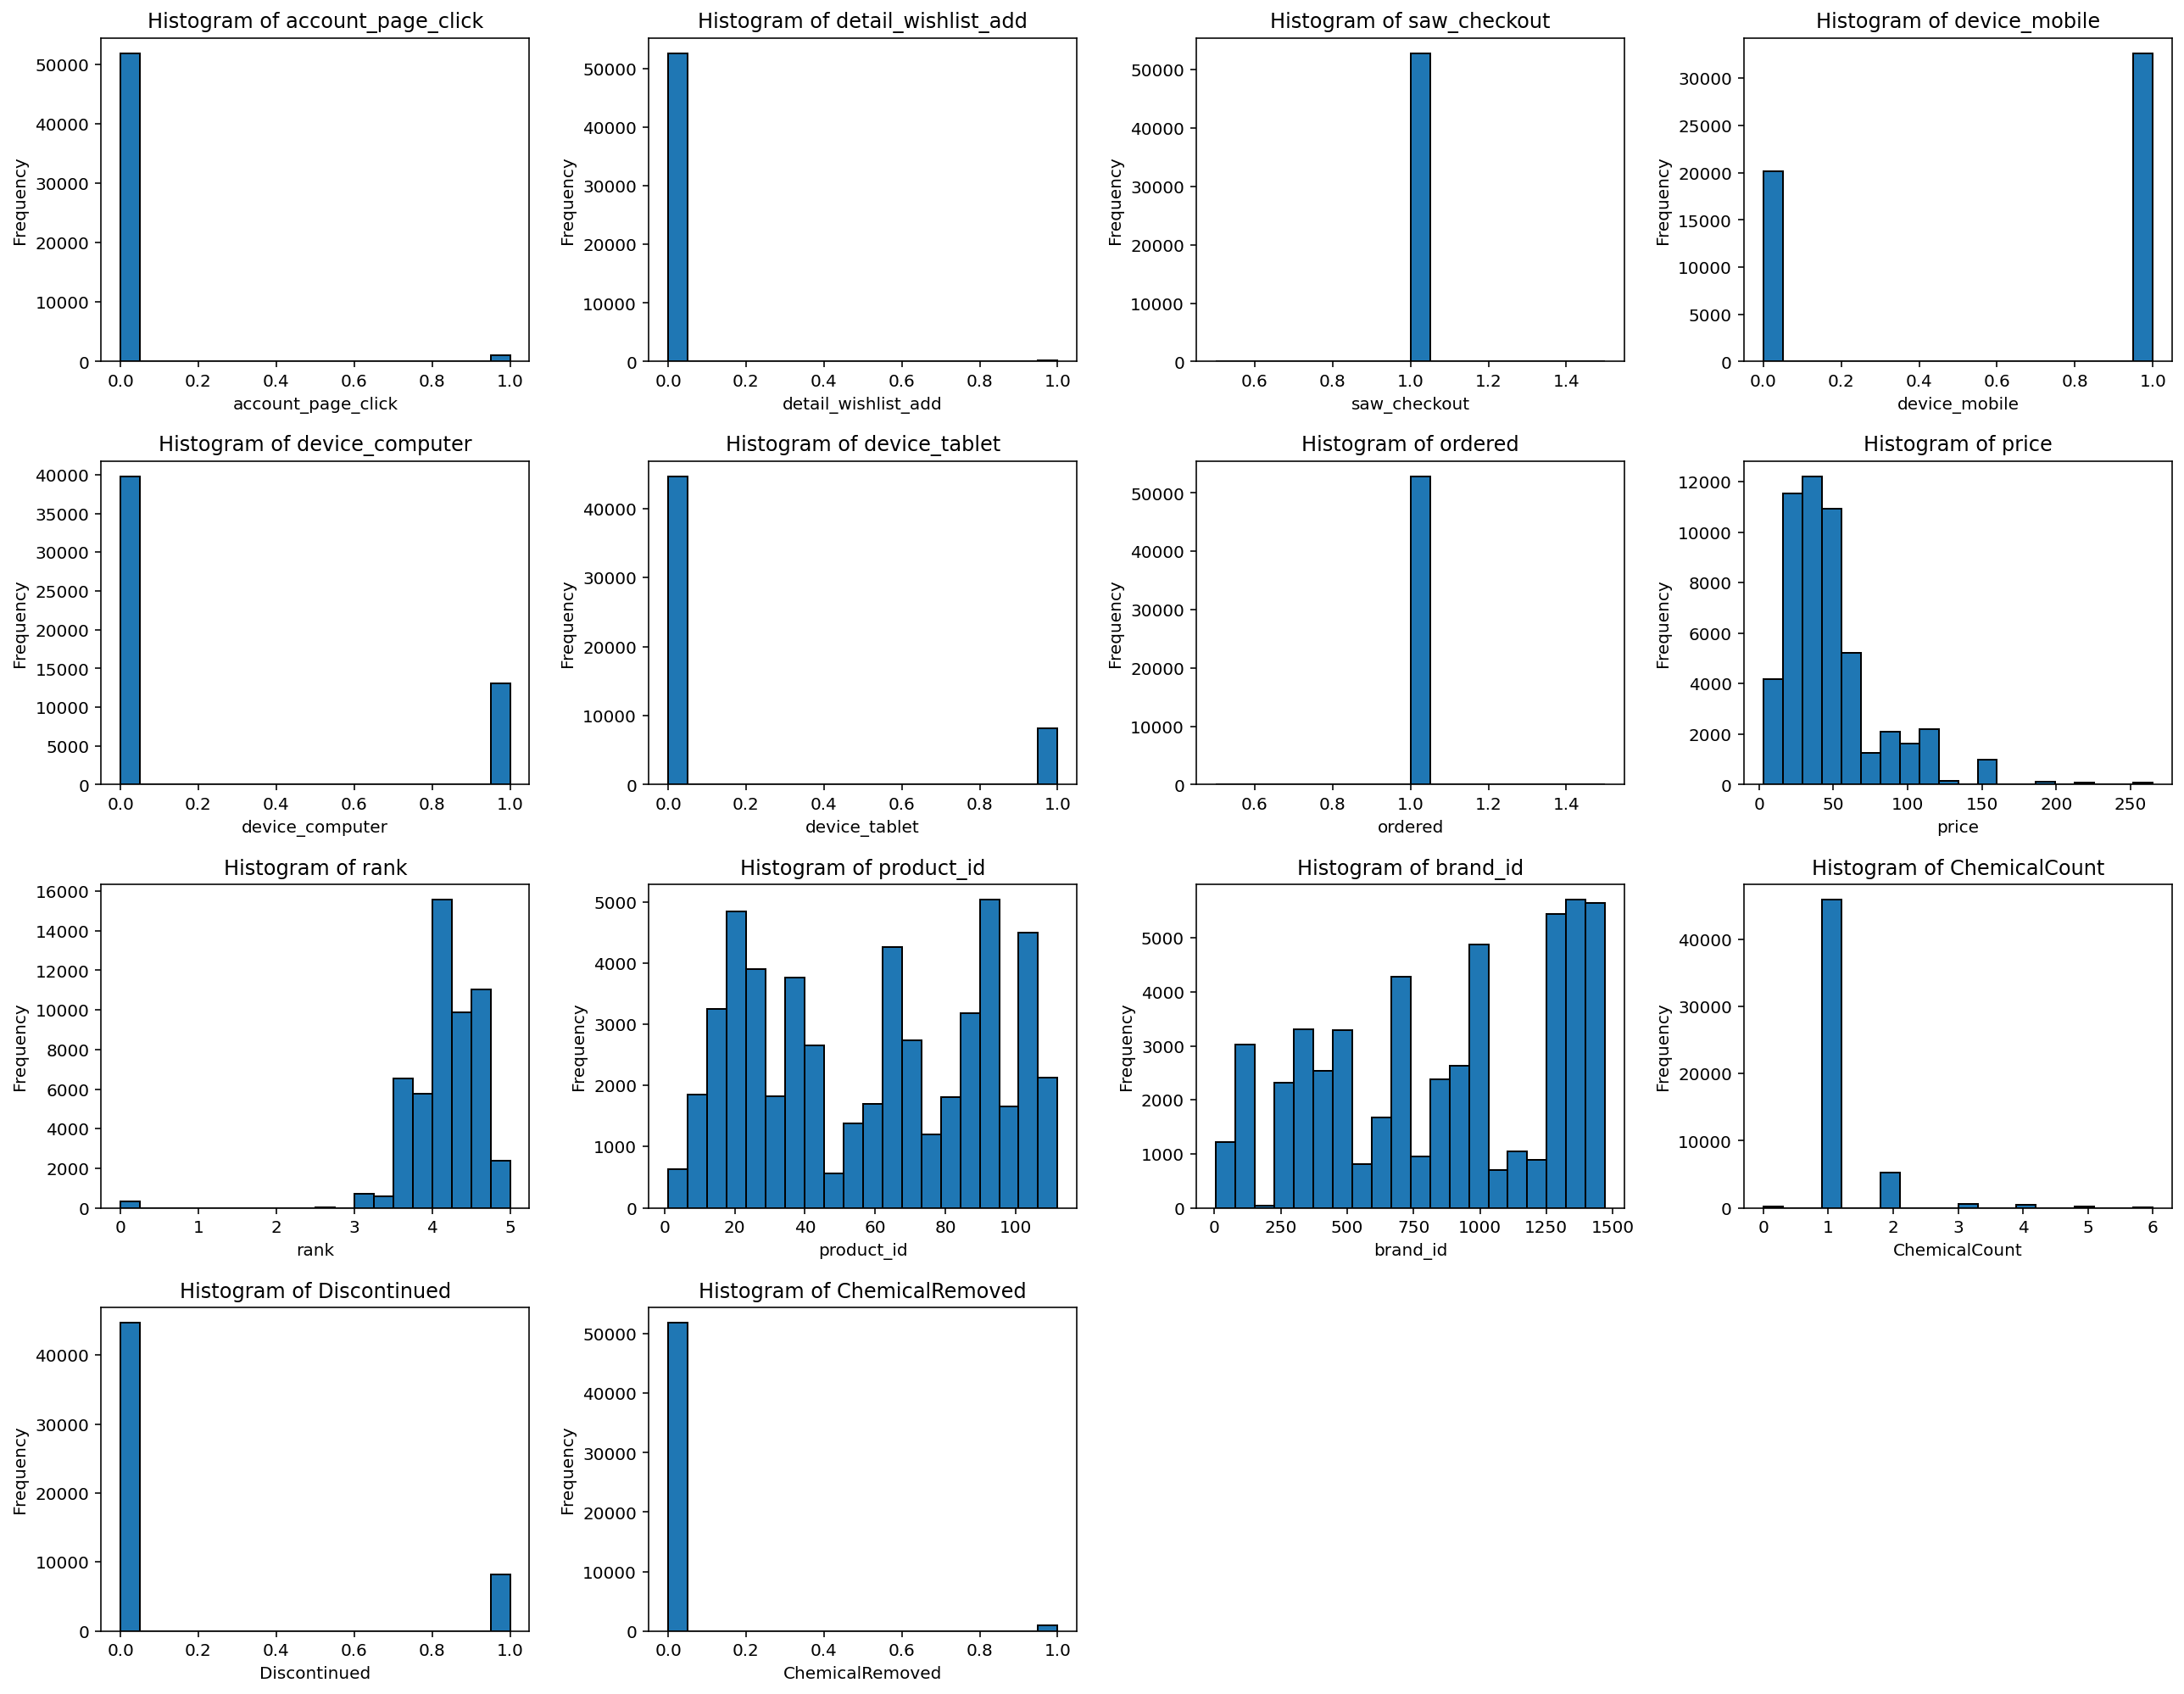

In [50]:
# list numerical predictors for histograms
predictors = [
    'account_page_click', 'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure
num_cols = 4
num_rows = (len(predictors) - 1) // num_cols + 1
plt.figure(figsize=(18, 14))  

# create histograms 
for i, predictor in enumerate(predictors):
    plt.subplot(num_rows, num_cols, i + 1)  
    plt.hist(sc_df[predictor], bins=20, edgecolor='black')
    plt.title(f'Histogram of {predictor}')
    plt.xlabel(predictor)
    plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()

#### Box Plots

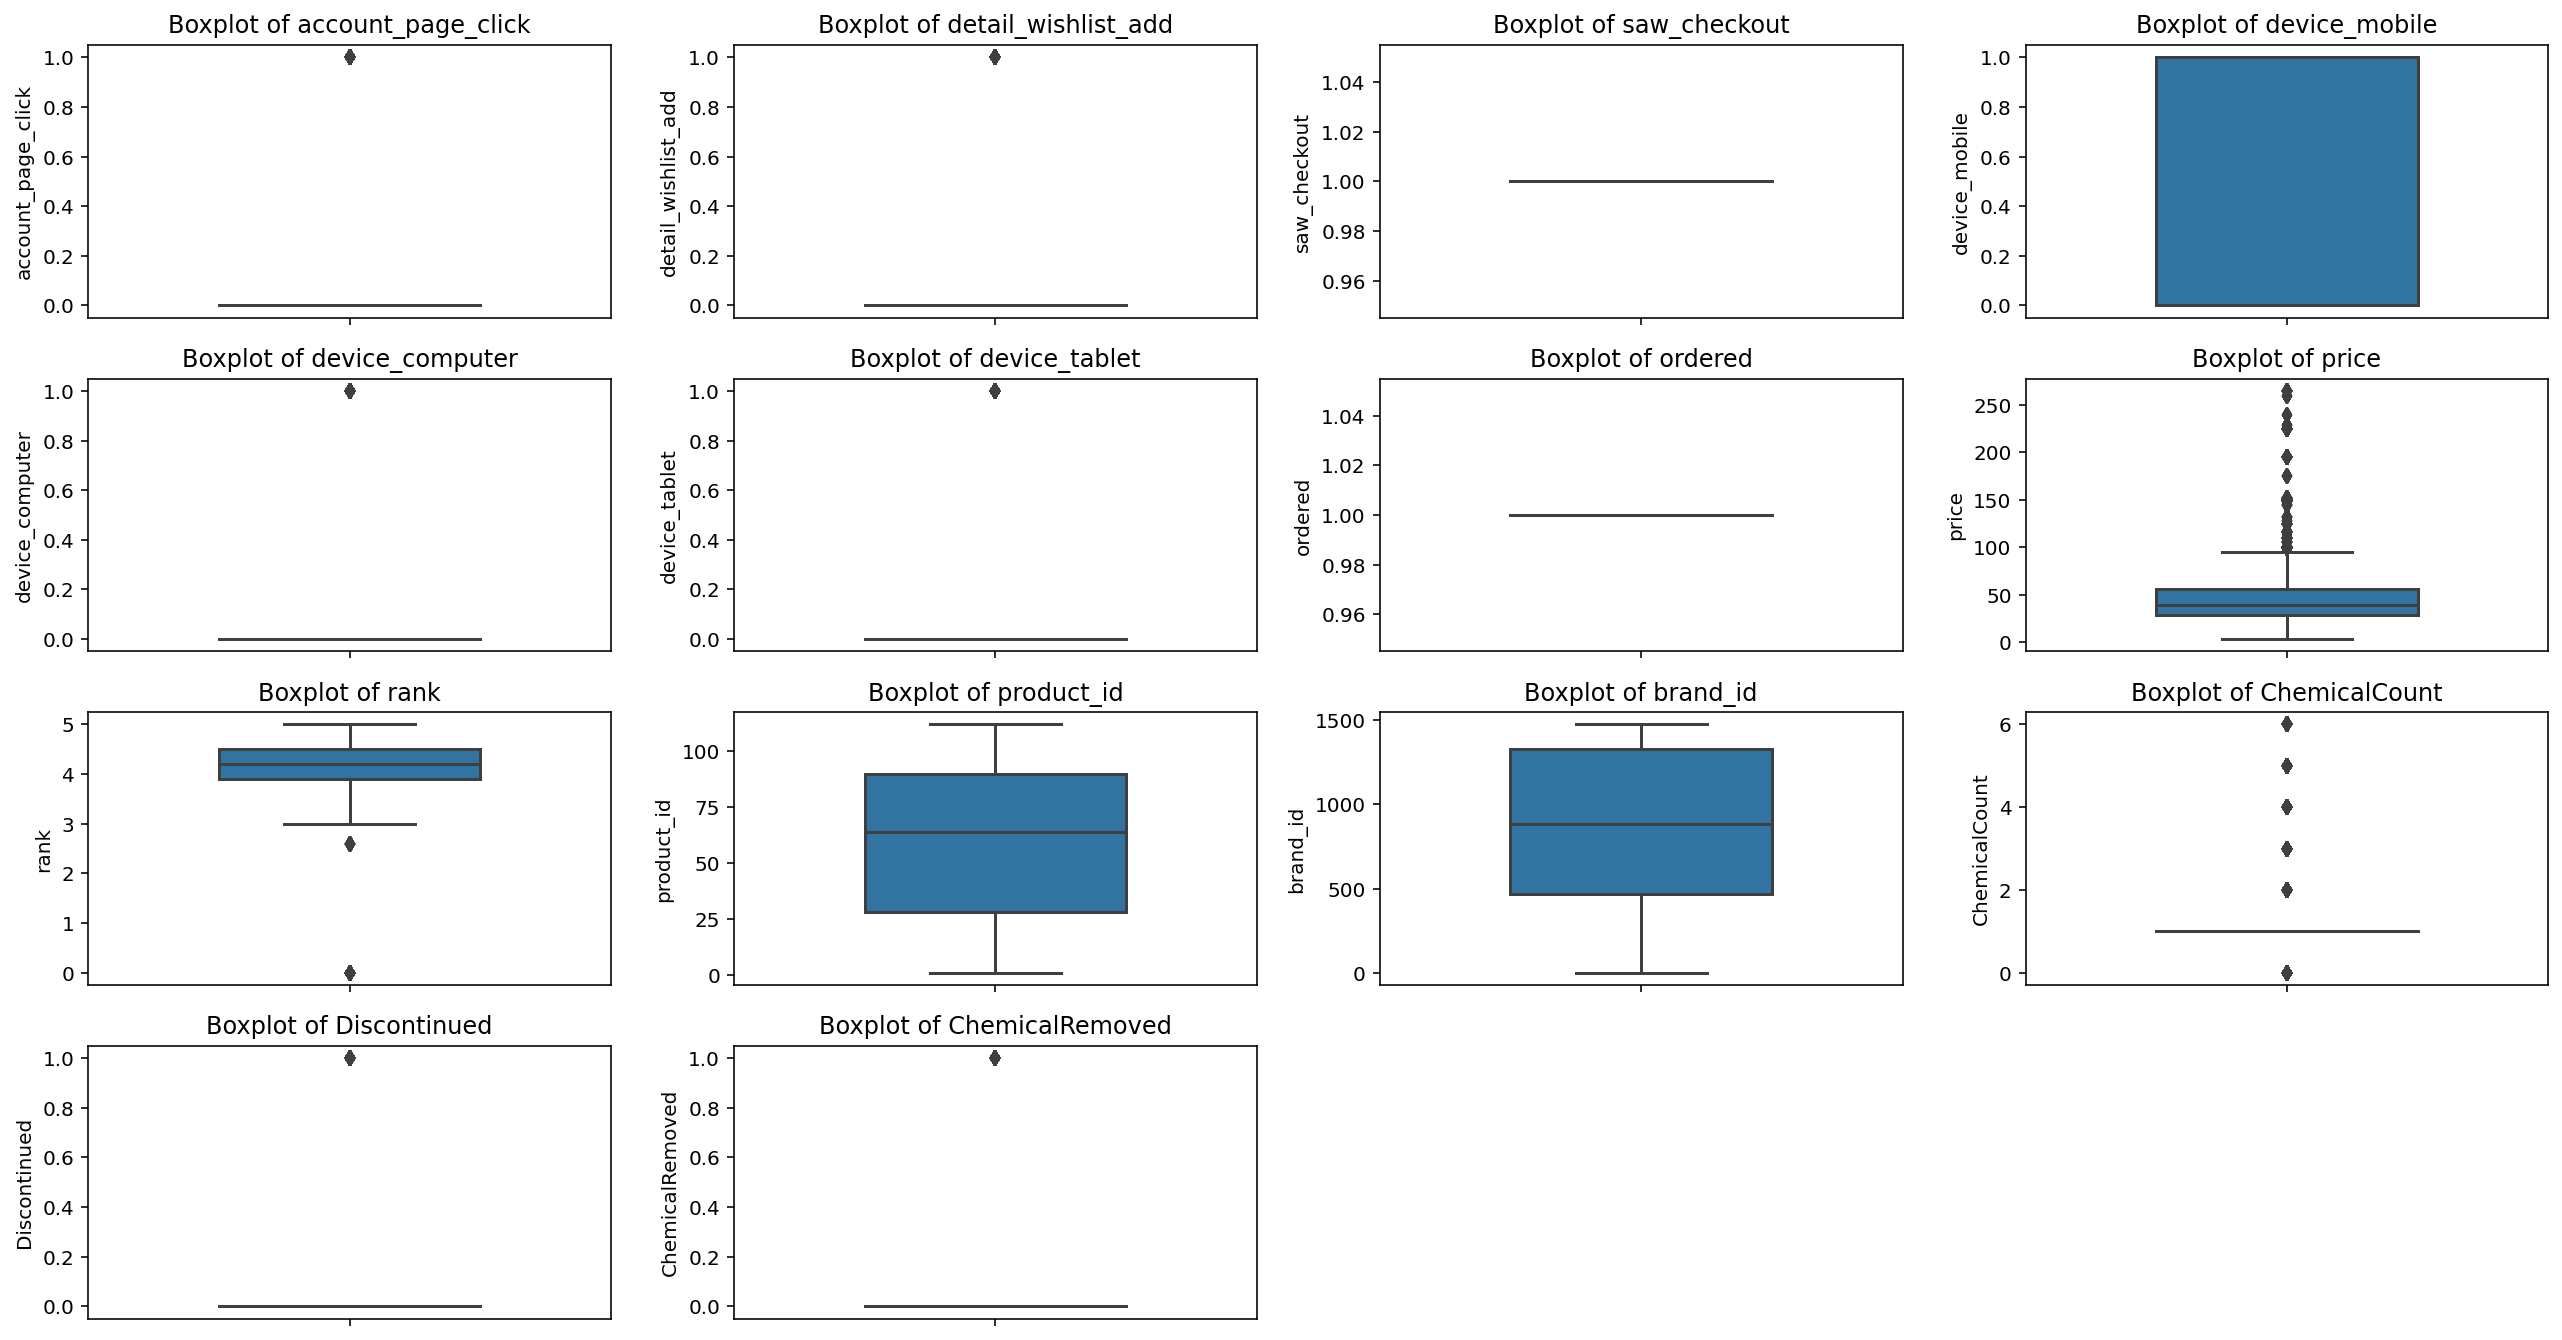

In [51]:
# list numerical predictors to create boxplots 
predictors = numerical_predictors = [
    'account_page_click','detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure for boxplots subplots 
plt.figure(figsize=(18, 14))  

# create boxplots for each predictor
for i, predictor in enumerate(predictors):
    plt.subplot(6, 4, i + 1)  
    sns.boxplot(data=sc_df, y=predictor, width=0.5)
    plt.title(f'Boxplot of {predictor}')
    plt.ylabel(predictor)

plt.tight_layout()  
plt.show()

#### Bar Plots 

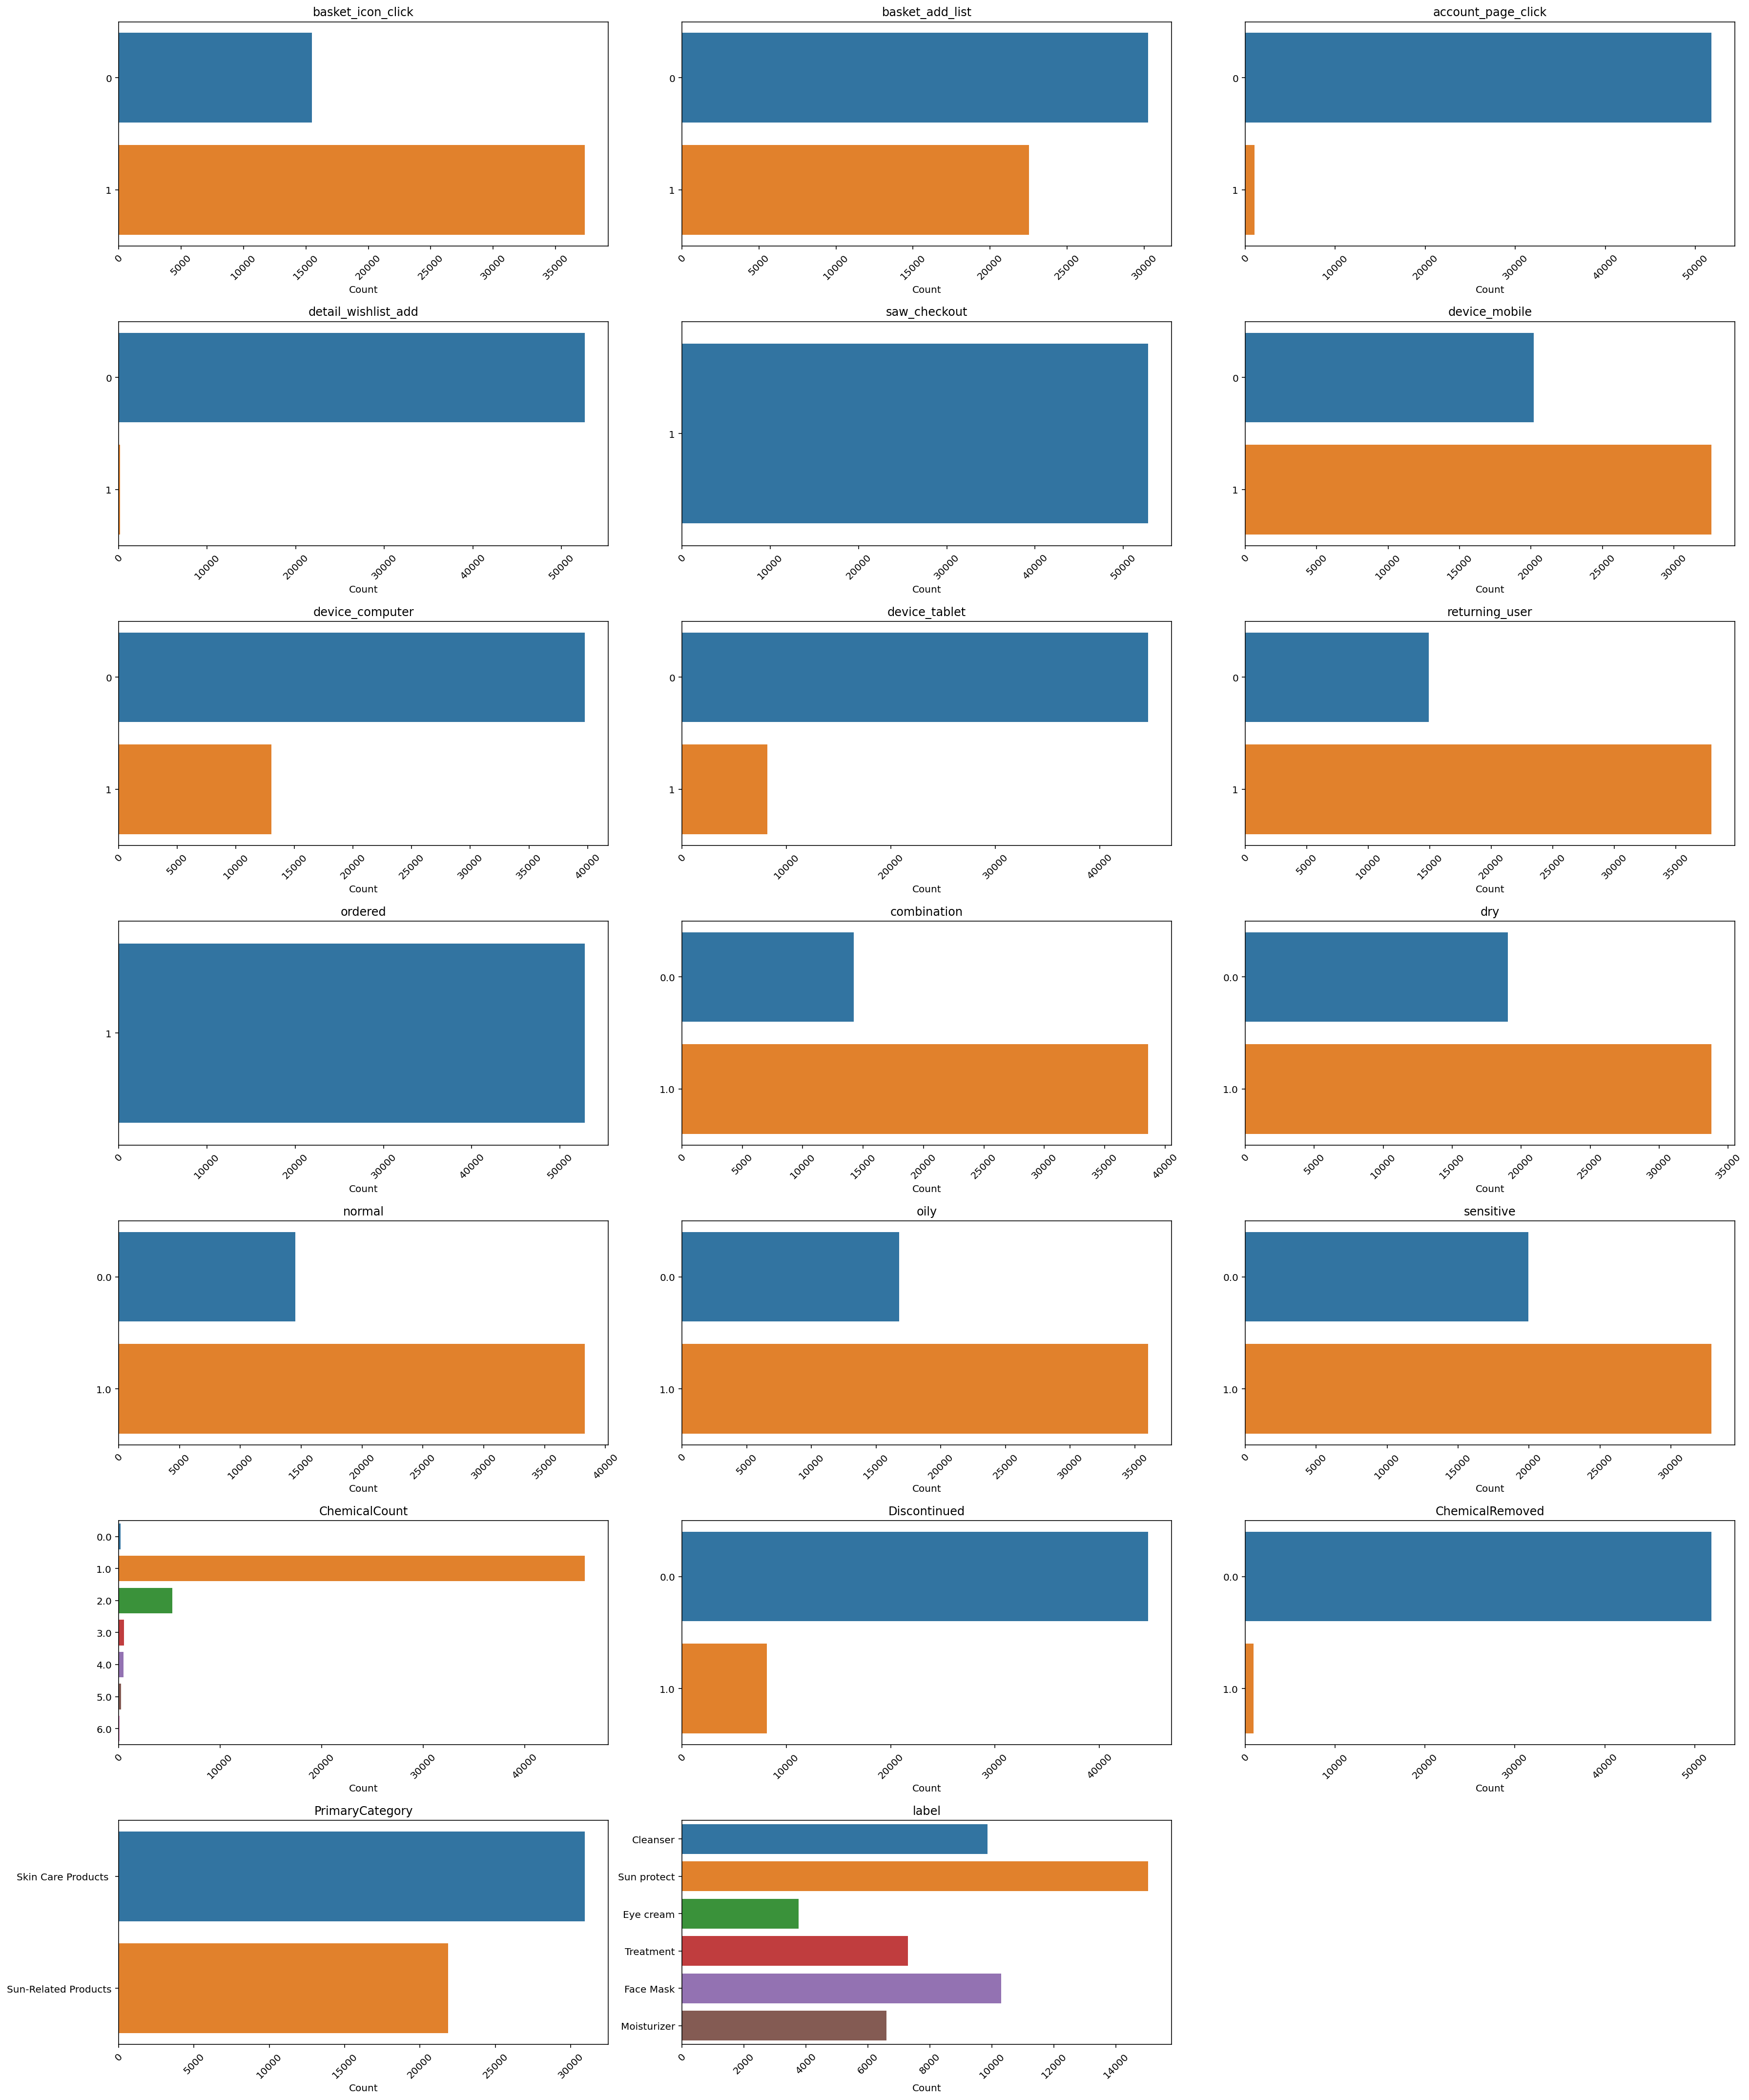

In [52]:
# list of selected columns for bar plot 
selected_columns = [
    'basket_icon_click', 'basket_add_list', 'account_page_click', 
    'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'returning_user', 
    'ordered', 'combination', 'dry', 'normal', 'oily', 'sensitive', 
    'ChemicalCount', 'Discontinued', 'ChemicalRemoved','PrimaryCategory', 'label'
]

# calculate the number of rows and columns for the subplot grid
num_cols = 3
num_rows = (len(selected_columns) - 1) // num_cols + 1

# create subplots and flatten axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 30))
axes = axes.flatten()

# iterate through selected columns and create horizontal countplots
for i, column in enumerate(selected_columns):
    sns.countplot(data=sc_df, y=column, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)  

    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')

# remove empty subplots
for i in range(len(selected_columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

From the plots we can dervie there is a class imbalance for 'ordered' and 'saw checkout'to resolve this we will apply SMOTE. 

#### Class Imbalance 
#### ('ordered' and 'saw_checkout')

In [53]:
# shuffle df to ensure randomness
sc_df_shuffled = sc_df.sample(frac=1, random_state=42)

# select 80% of the records where the class label is 1 for both columns (only 1 class exists [1])
num_records_to_change = int(len(sc_df_shuffled[sc_df_shuffled['ordered'] == 1]) * 0.8)
records_to_change_ordered = sc_df_shuffled[sc_df_shuffled['ordered'] == 1].head(num_records_to_change)
records_to_change_saw_checkout = sc_df_shuffled[sc_df_shuffled['saw_checkout'] == 1].head(num_records_to_change)

# change the class label for the selected records to 0
records_to_change_ordered['ordered'] = 0
records_to_change_saw_checkout['saw_checkout'] = 0
sc_df.loc[records_to_change_ordered.index, 'ordered'] = records_to_change_ordered['ordered']
sc_df.loc[records_to_change_saw_checkout.index, 'saw_checkout'] = records_to_change_saw_checkout['saw_checkout']

In [54]:
# check distribution of classes after adding class
print("\nAfter balancing:")
print(sc_df['ordered'].value_counts())
print(sc_df['saw_checkout'].value_counts())


After balancing:
0    42256
1    10565
Name: ordered, dtype: int64
0    42256
1    10565
Name: saw_checkout, dtype: int64


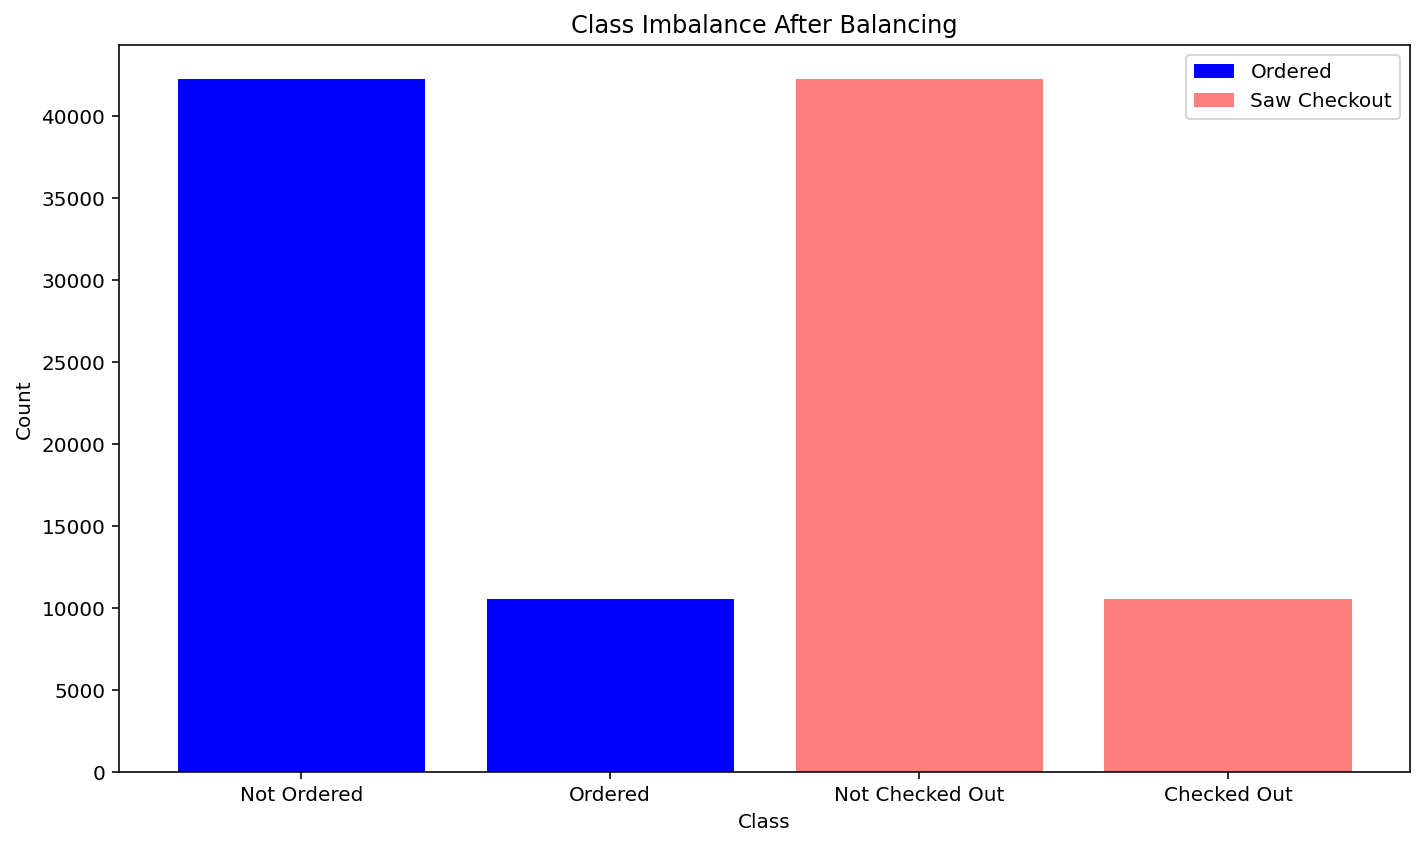

In [55]:
plt.figure(figsize=(10, 6))

# Bar plot for 'ordered' column
plt.bar(['Not Ordered', 'Ordered'], sc_df['ordered'].value_counts(), color='blue', label='Ordered')

# Bar plot for 'saw_checkout' column
plt.bar(['Not Checked Out', 'Checked Out'], sc_df['saw_checkout'].value_counts(), color='red', label='Saw Checkout', alpha=0.5)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Imbalance After Balancing')
plt.legend()
plt.tight_layout()

plt.show()

In [73]:
# craete a copy of the df 
balanced_df = sc_df.copy()

# specify the columns to balance
columns_to_balance = ['ordered', 'saw_checkout']

# create a separate SMOTE object for each column with its desired sampling strategy
smote_ordered = SMOTE(random_state=42)
smote_saw_checkout = SMOTE(random_state=42)

# apply SMOTE to each column selected
for col, smote_obj in zip(columns_to_balance, [smote_ordered, smote_saw_checkout]):
    X_resampled, y_resampled = smote_obj.fit_resample(balanced_df[[col]], balanced_df[col])
    # Update DataFrame with resampled data
    balanced_df[col] = y_resampled

# check the class distribution after balancing
print("After balancing:")
for col in columns_to_balance:
    print(balanced_df[col].value_counts())

After balancing:
0.0    4903
1.0    4003
Name: ordered, dtype: int64
0.0    4903
1.0    4003
Name: saw_checkout, dtype: int64


In [74]:
checkout_distribution = balanced_df['saw_checkout'].value_counts(normalize=True)
print("Class Distribution for Saw Check Out:\n", checkout_distribution)

ordered_distribution = balanced_df['ordered'].value_counts(normalize=True)
print("Class Distribution for Ordered:\n", ordered_distribution)

Class Distribution for Saw Check Out:
 0.0    0.550528
1.0    0.449472
Name: saw_checkout, dtype: float64
Class Distribution for Ordered:
 0.0    0.550528
1.0    0.449472
Name: ordered, dtype: float64


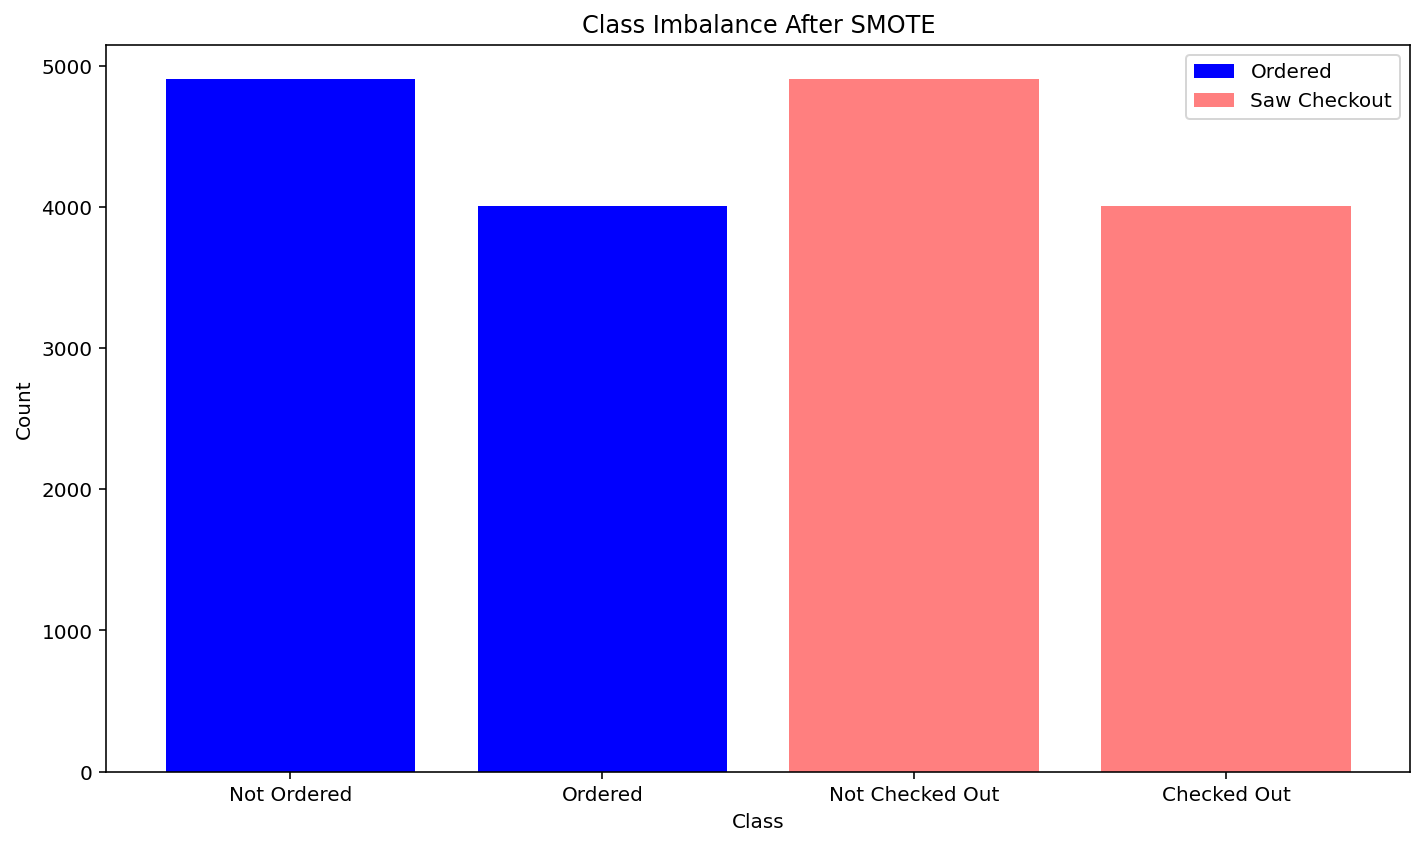

In [75]:
plt.figure(figsize=(10, 6))

# Bar plot for 'ordered' column
plt.bar(['Not Ordered', 'Ordered'], 
        balanced_df['ordered'].value_counts(), color='blue', label='Ordered')

# Bar plot for 'saw_checkout' column
plt.bar(['Not Checked Out', 'Checked Out'], 
        balanced_df['saw_checkout'].value_counts(), color='red', label='Saw Checkout', alpha=0.5)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Imbalance After SMOTE')
plt.legend()
plt.tight_layout()

plt.show()

In [76]:
balanced_df.isnull().sum() # remove null values created after SMOTE 

UserID                     0
basket_icon_click          0
basket_add_list            0
account_page_click         0
detail_wishlist_add        0
saw_checkout           43915
device_mobile              0
device_computer            0
device_tablet              0
returning_user             0
ordered                43915
label                      0
brand                      0
name                       0
price                      0
rank                       0
ingredients                0
combination                0
dry                        0
normal                     0
oily                       0
sensitive                  0
product_id                 0
brand_id                   0
PrimaryCategory            0
SubCategory                0
ChemicalName               0
ChemicalCount              0
Discontinued               0
ChemicalRemoved            0
dtype: int64

In [77]:
# drop rows with misisng data 
balanced_df.dropna(inplace=True) 

In [78]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8906 entries, 1371 to 83871
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               8906 non-null   object 
 1   basket_icon_click    8906 non-null   int64  
 2   basket_add_list      8906 non-null   int64  
 3   account_page_click   8906 non-null   int64  
 4   detail_wishlist_add  8906 non-null   int64  
 5   saw_checkout         8906 non-null   float64
 6   device_mobile        8906 non-null   int64  
 7   device_computer      8906 non-null   int64  
 8   device_tablet        8906 non-null   int64  
 9   returning_user       8906 non-null   int64  
 10  ordered              8906 non-null   float64
 11  label                8906 non-null   object 
 12  brand                8906 non-null   object 
 13  name                 8906 non-null   object 
 14  price                8906 non-null   float64
 15  rank                 8906 non-null

The decrease in data size post-SMOTE arises from the generation of synthetic samples to balance class distribution. SMOTE may remove or undersample instances to prevent overfitting and maintain a balanced representation of minority and majority classes, ensuring effective synthesis while preserving dataset integrity.

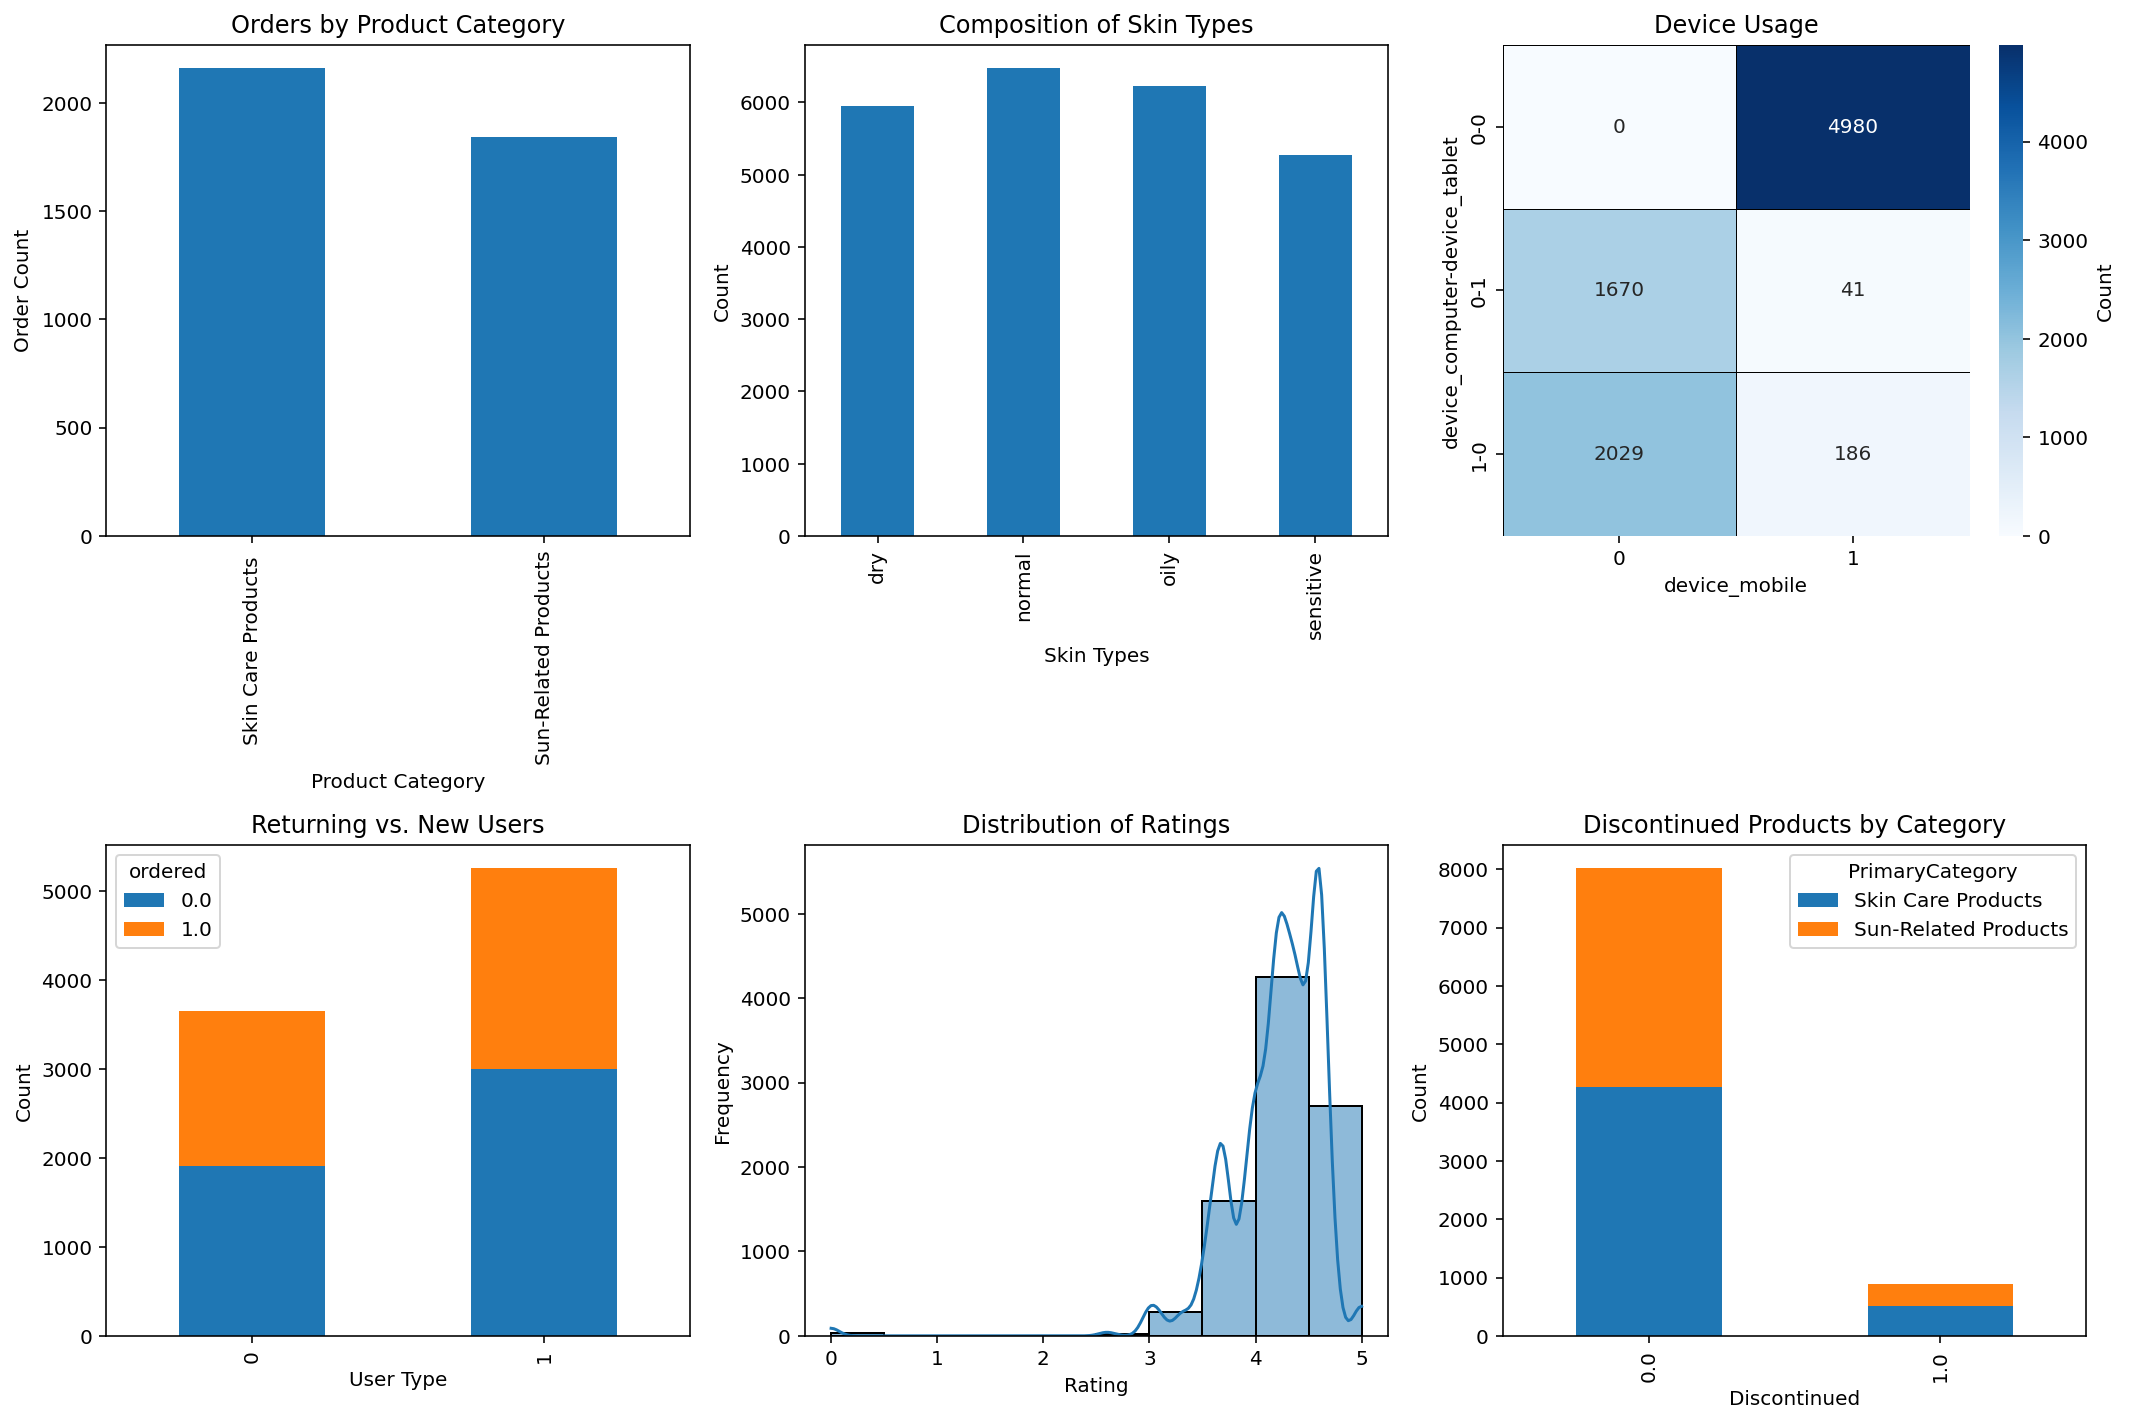

In [79]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# count of ordered by product category
order_count_by_category = balanced_df.groupby('PrimaryCategory')['ordered'].sum()
order_count_by_category.plot(kind='bar', ax=axs[0, 0], 
                             xlabel='Product Category', ylabel='Order Count', 
                             title='Orders by Product Category')

# composition of skin types
skin_type_counts = balanced_df[['dry', 'normal', 'oily', 'sensitive']].sum()
skin_type_counts.plot(kind='bar', stacked=True, ax=axs[0, 1], 
                      xlabel='Skin Types', ylabel='Count', 
                      title='Composition of Skin Types')

# device usage 
device_usage = balanced_df[['device_computer', 'device_tablet', 'device_mobile']].astype(int)
device_usage_counts = device_usage.groupby(device_usage.columns.tolist()).size().unstack(fill_value=0)
sns.heatmap(device_usage_counts, ax=axs[0, 2], cmap="Blues", annot=True, fmt="d",
            cbar_kws={'label': 'Count'}, 
            linewidths=0.5, linecolor='black')
axs[0, 2].set_title('Device Usage')

# returning vs new users 
returning_new_users = pd.crosstab(balanced_df['returning_user'], 
                                  balanced_df['ordered'])

returning_new_users.plot(kind='bar', stacked=True, ax=axs[1, 0], 
                         xlabel='User Type', ylabel='Count', 
                         title='Returning vs. New Users')

# distribution of ratings 
sns.histplot(data=balanced_df, x='rank', bins=10, kde=True, ax=axs[1, 1])
axs[1, 1].set_xlabel('Rating')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Distribution of Ratings')

# discontinued products 
discontinued_category_counts = pd.crosstab(index=balanced_df['Discontinued'], 
                                           columns=balanced_df['PrimaryCategory'])

discontinued_category_counts.plot(kind='bar', stacked=True, ax=axs[1, 2], 
                                  xlabel='Discontinued', ylabel='Count', 
                                  title='Discontinued Products by Category')

plt.tight_layout()
plt.show()

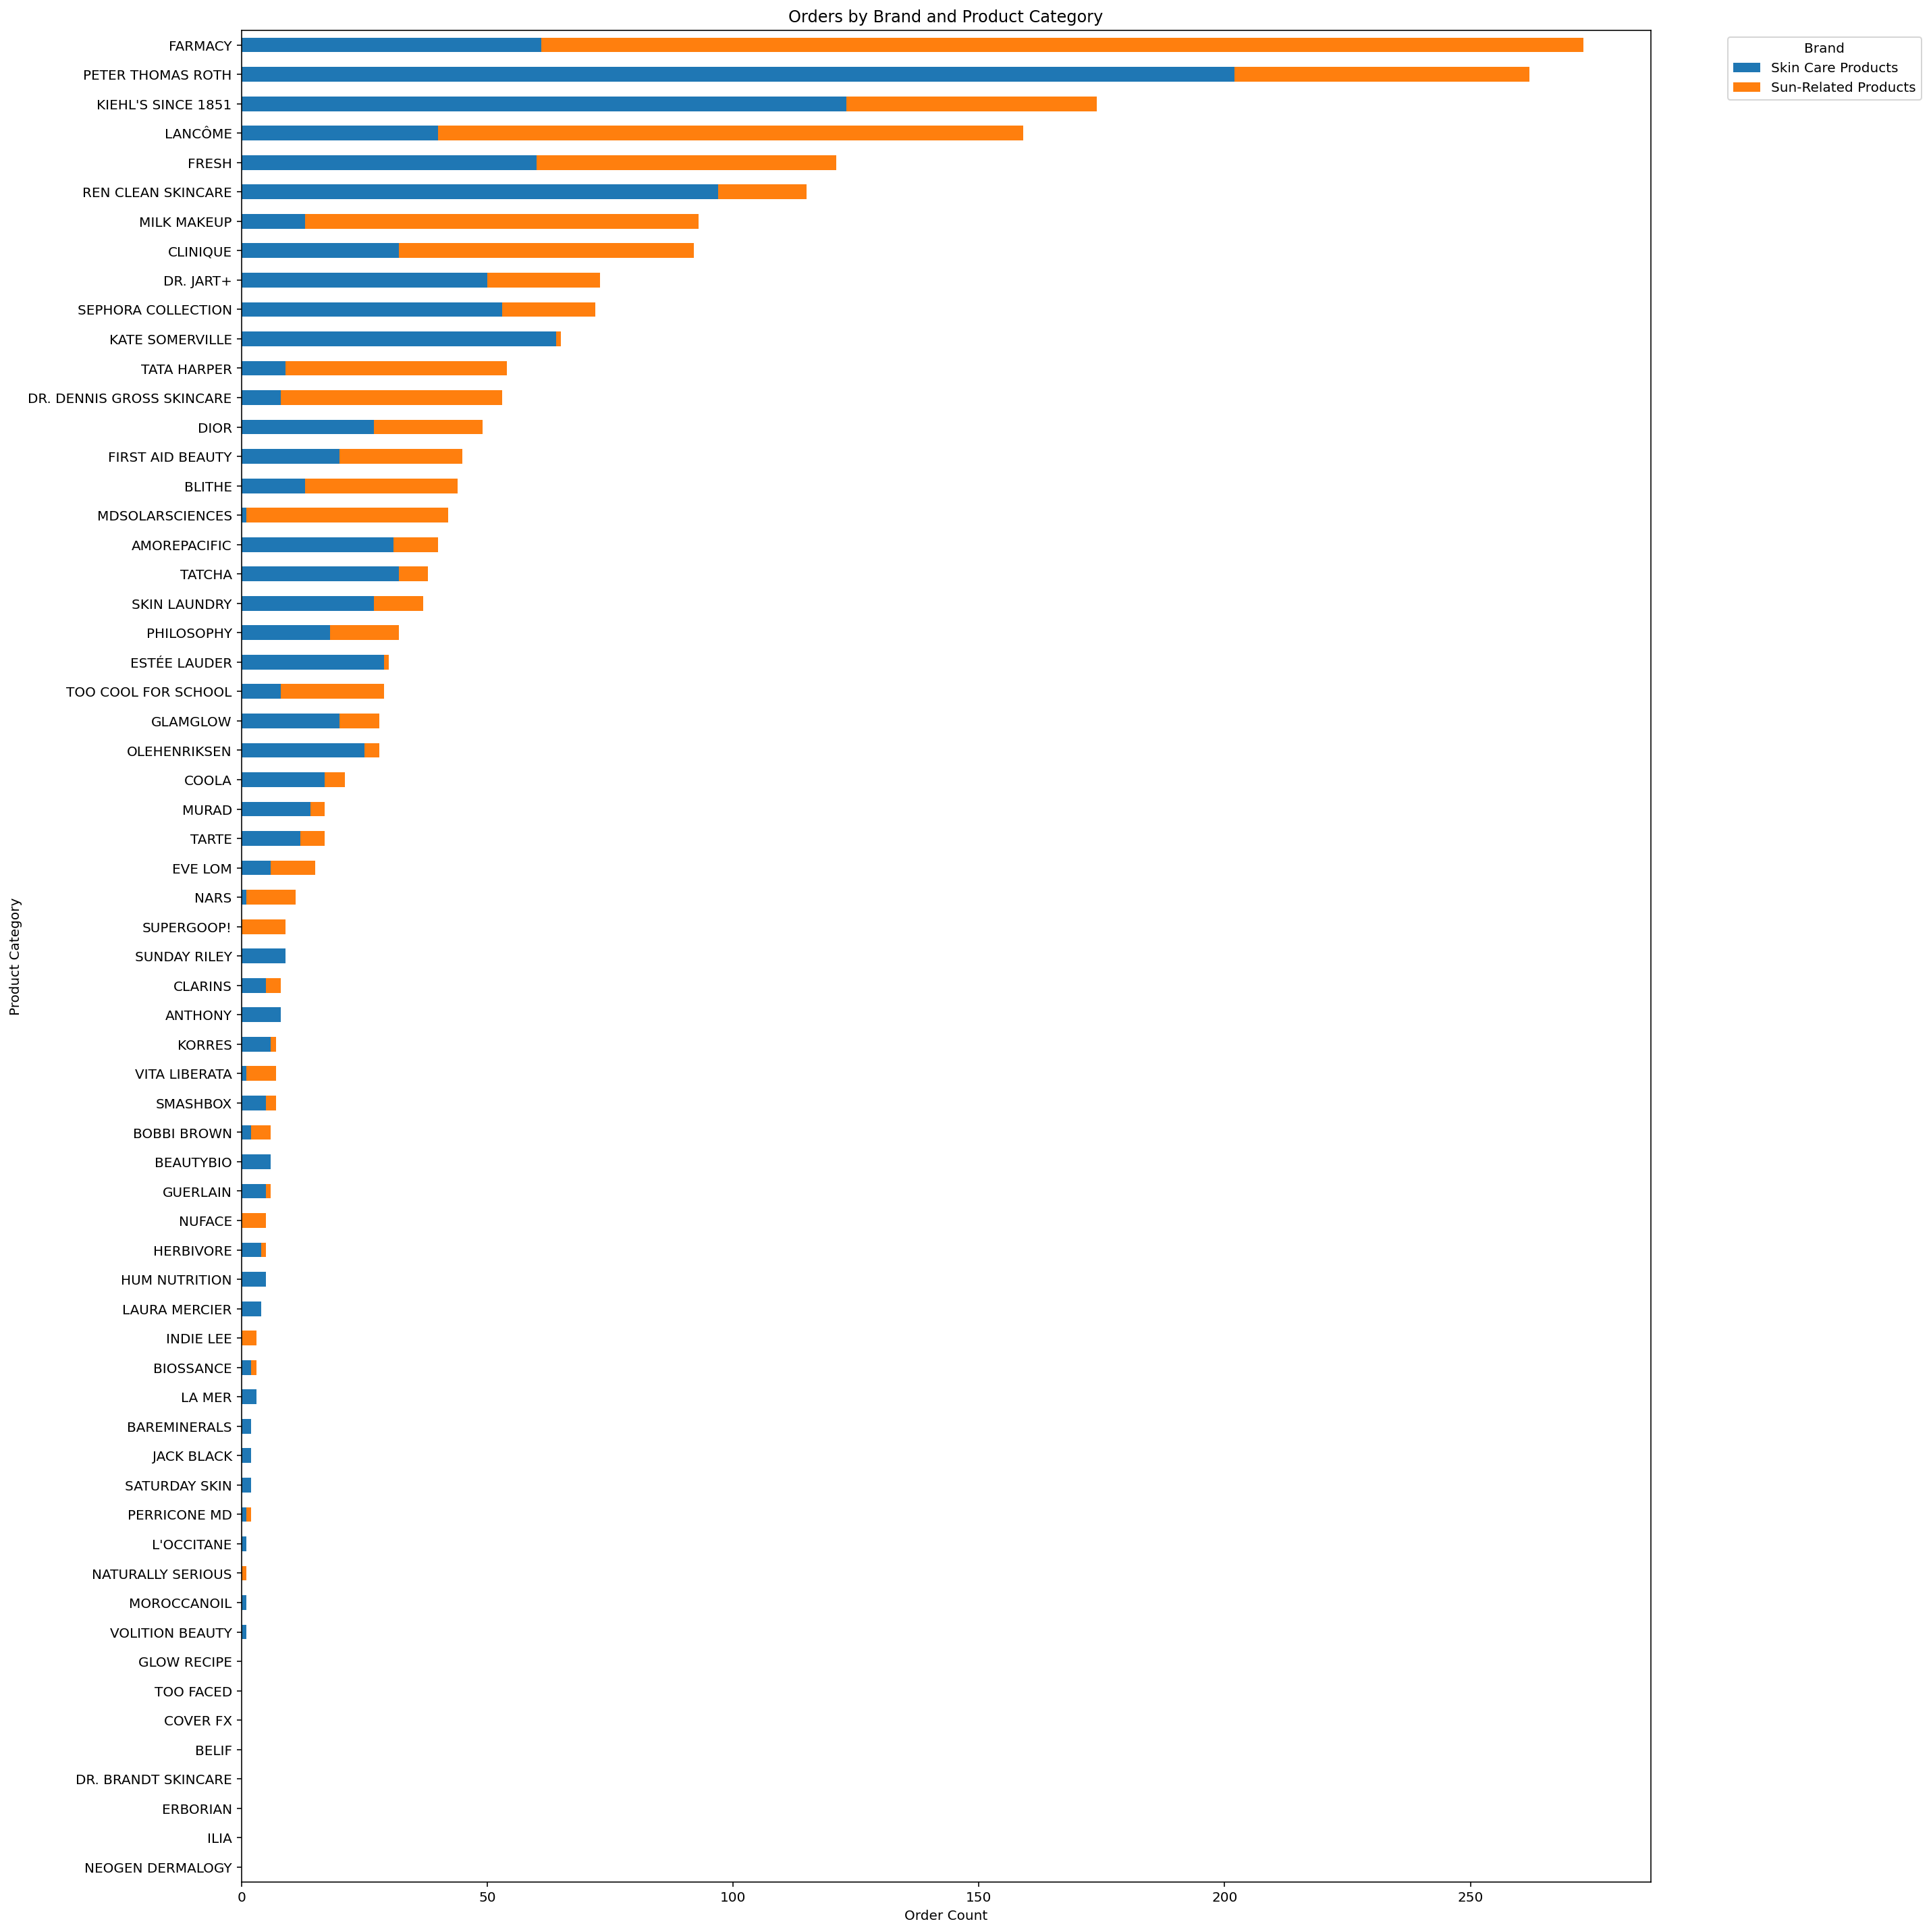

In [63]:
#  order count by brand and product category
order_count_by_brand_category = balanced_df.groupby(['brand', 'PrimaryCategory'])['ordered'].sum().unstack().fillna(0)
order_count_by_brand = order_count_by_brand_category.sum(axis=1).sort_values()
order_count_by_brand_category = order_count_by_brand_category.loc[order_count_by_brand.index]


order_count_by_brand_category.plot(kind='barh', stacked=True, figsize=(20, 20))
plt.xlabel('Order Count')
plt.ylabel('Product Category')
plt.title('Orders by Brand and Product Category')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

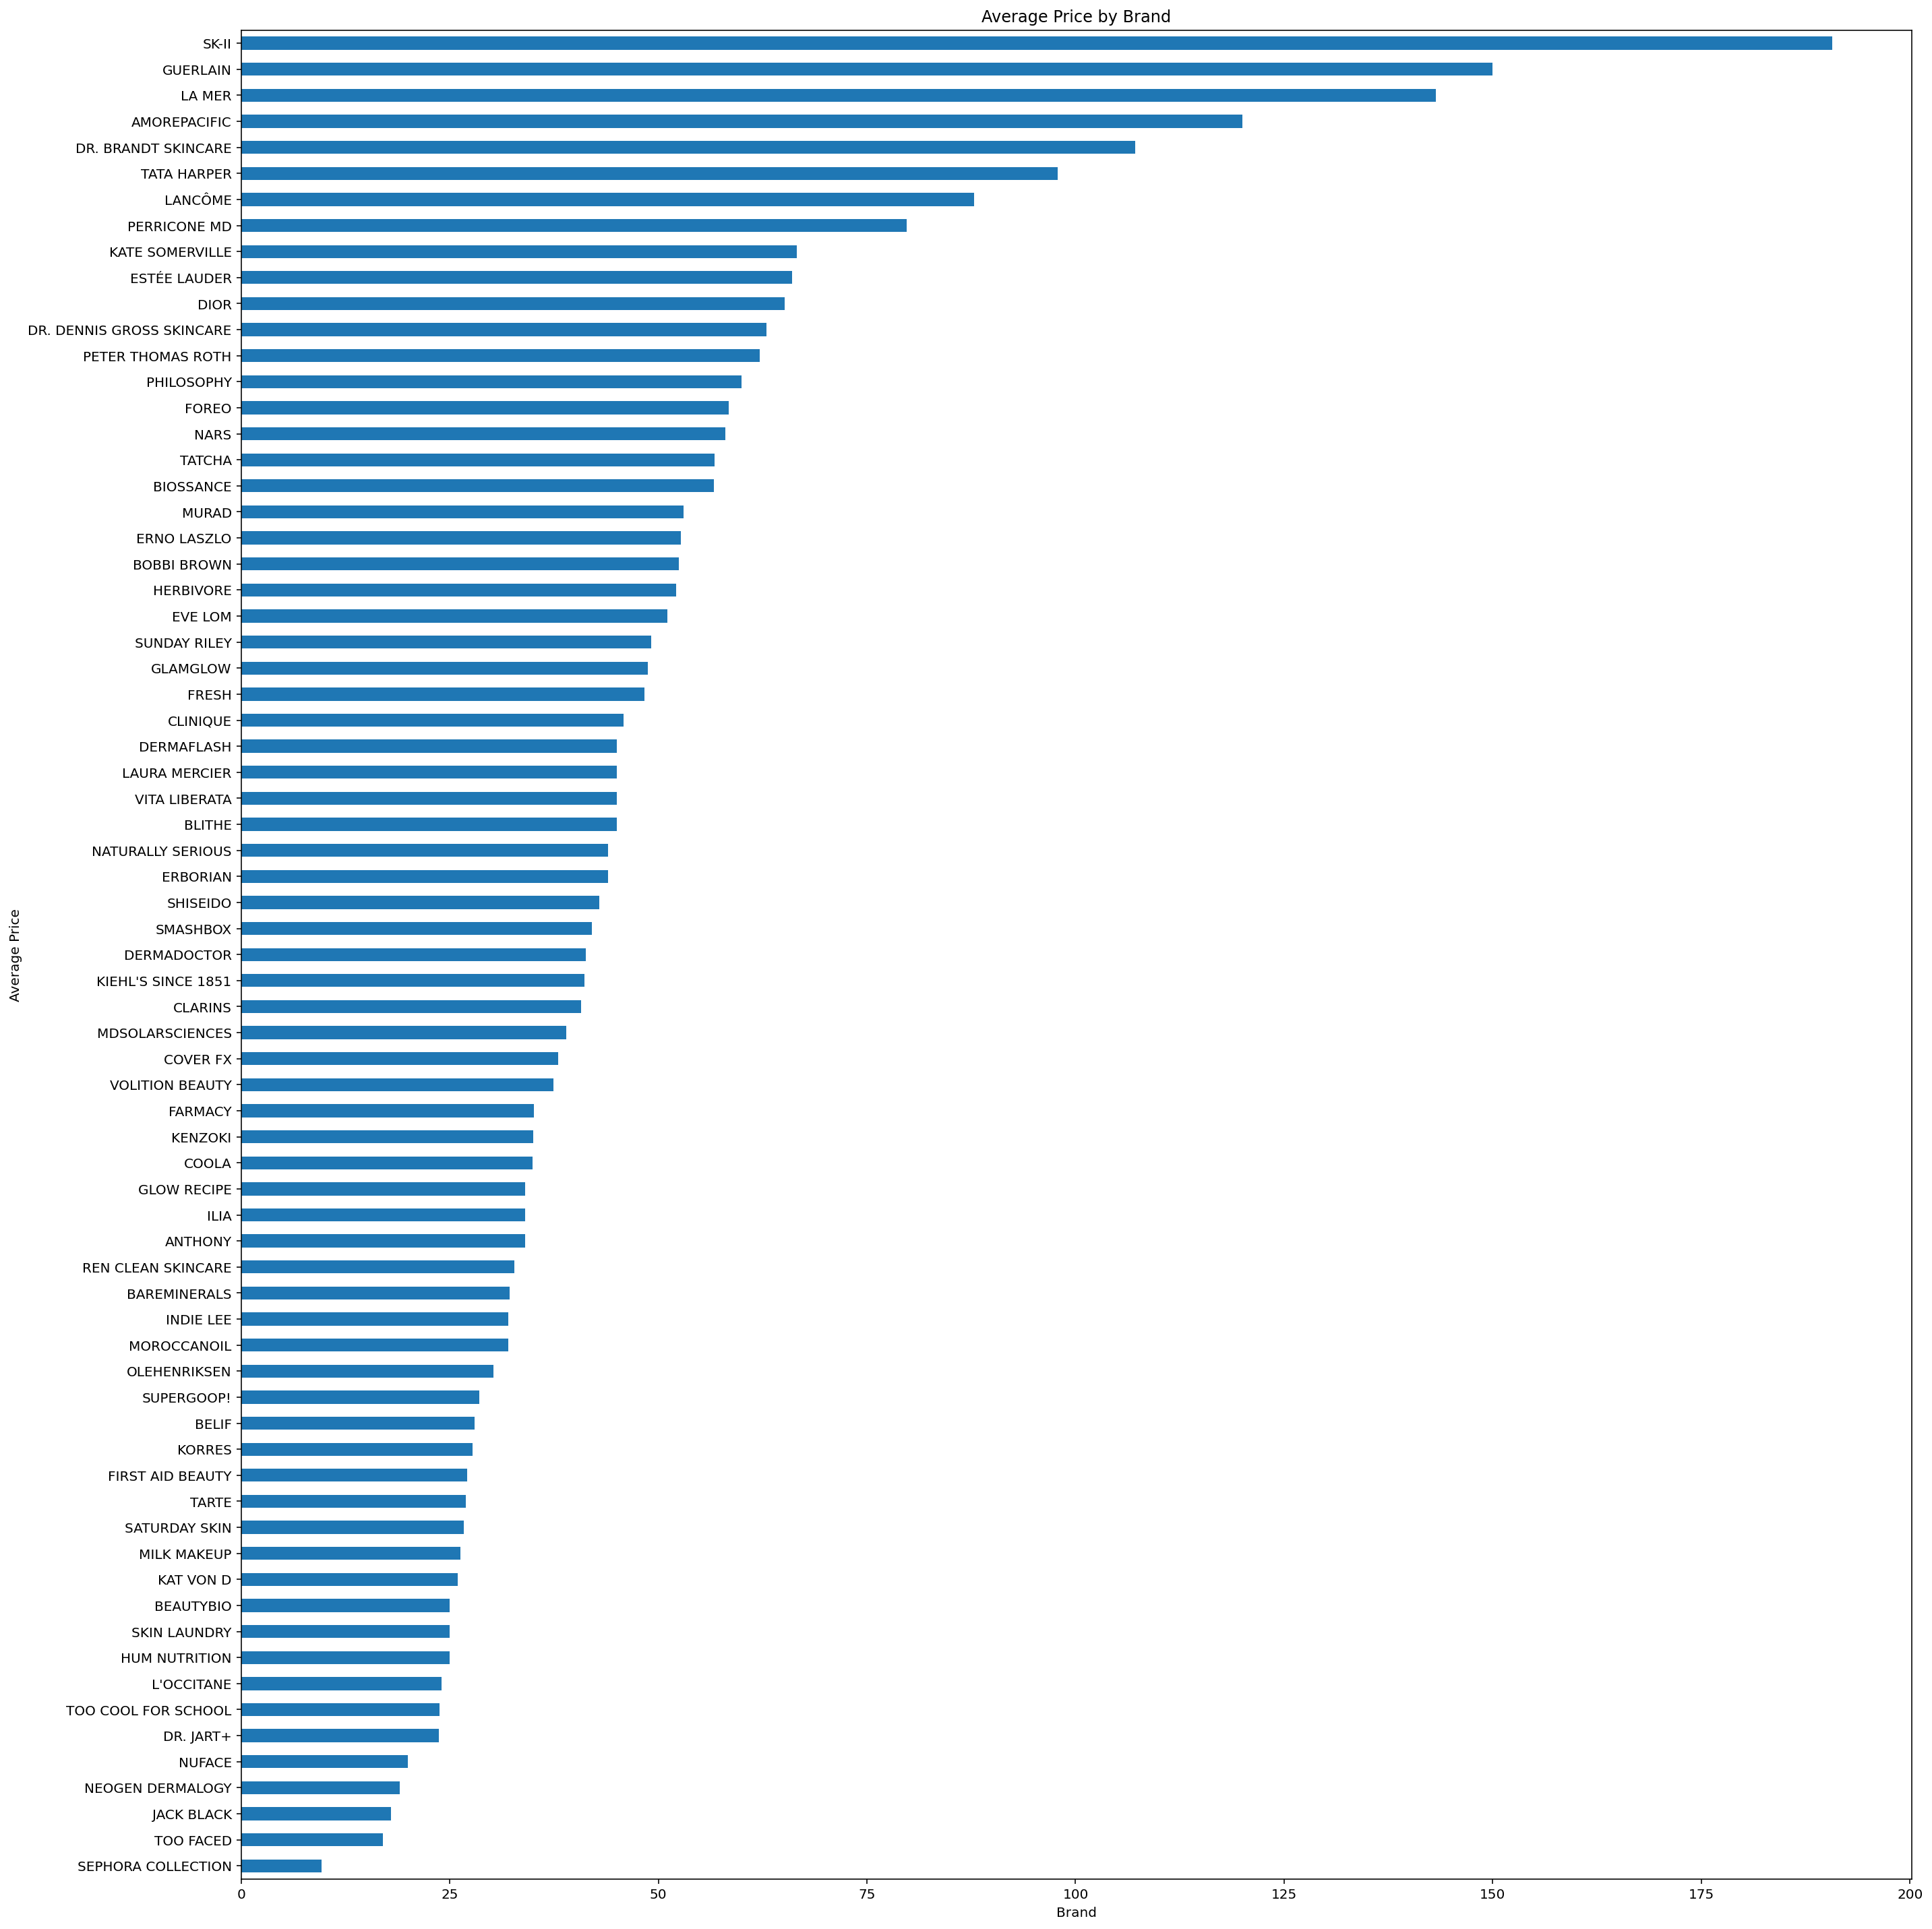

In [80]:
# plot the average price by brand
avg_price_by_brand = balanced_df.groupby('brand')['price'].mean().sort_values()

plt.figure(figsize=(20, 20))
avg_price_by_brand.plot(kind='barh')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.title('Average Price by Brand')
plt.tight_layout()
plt.show()

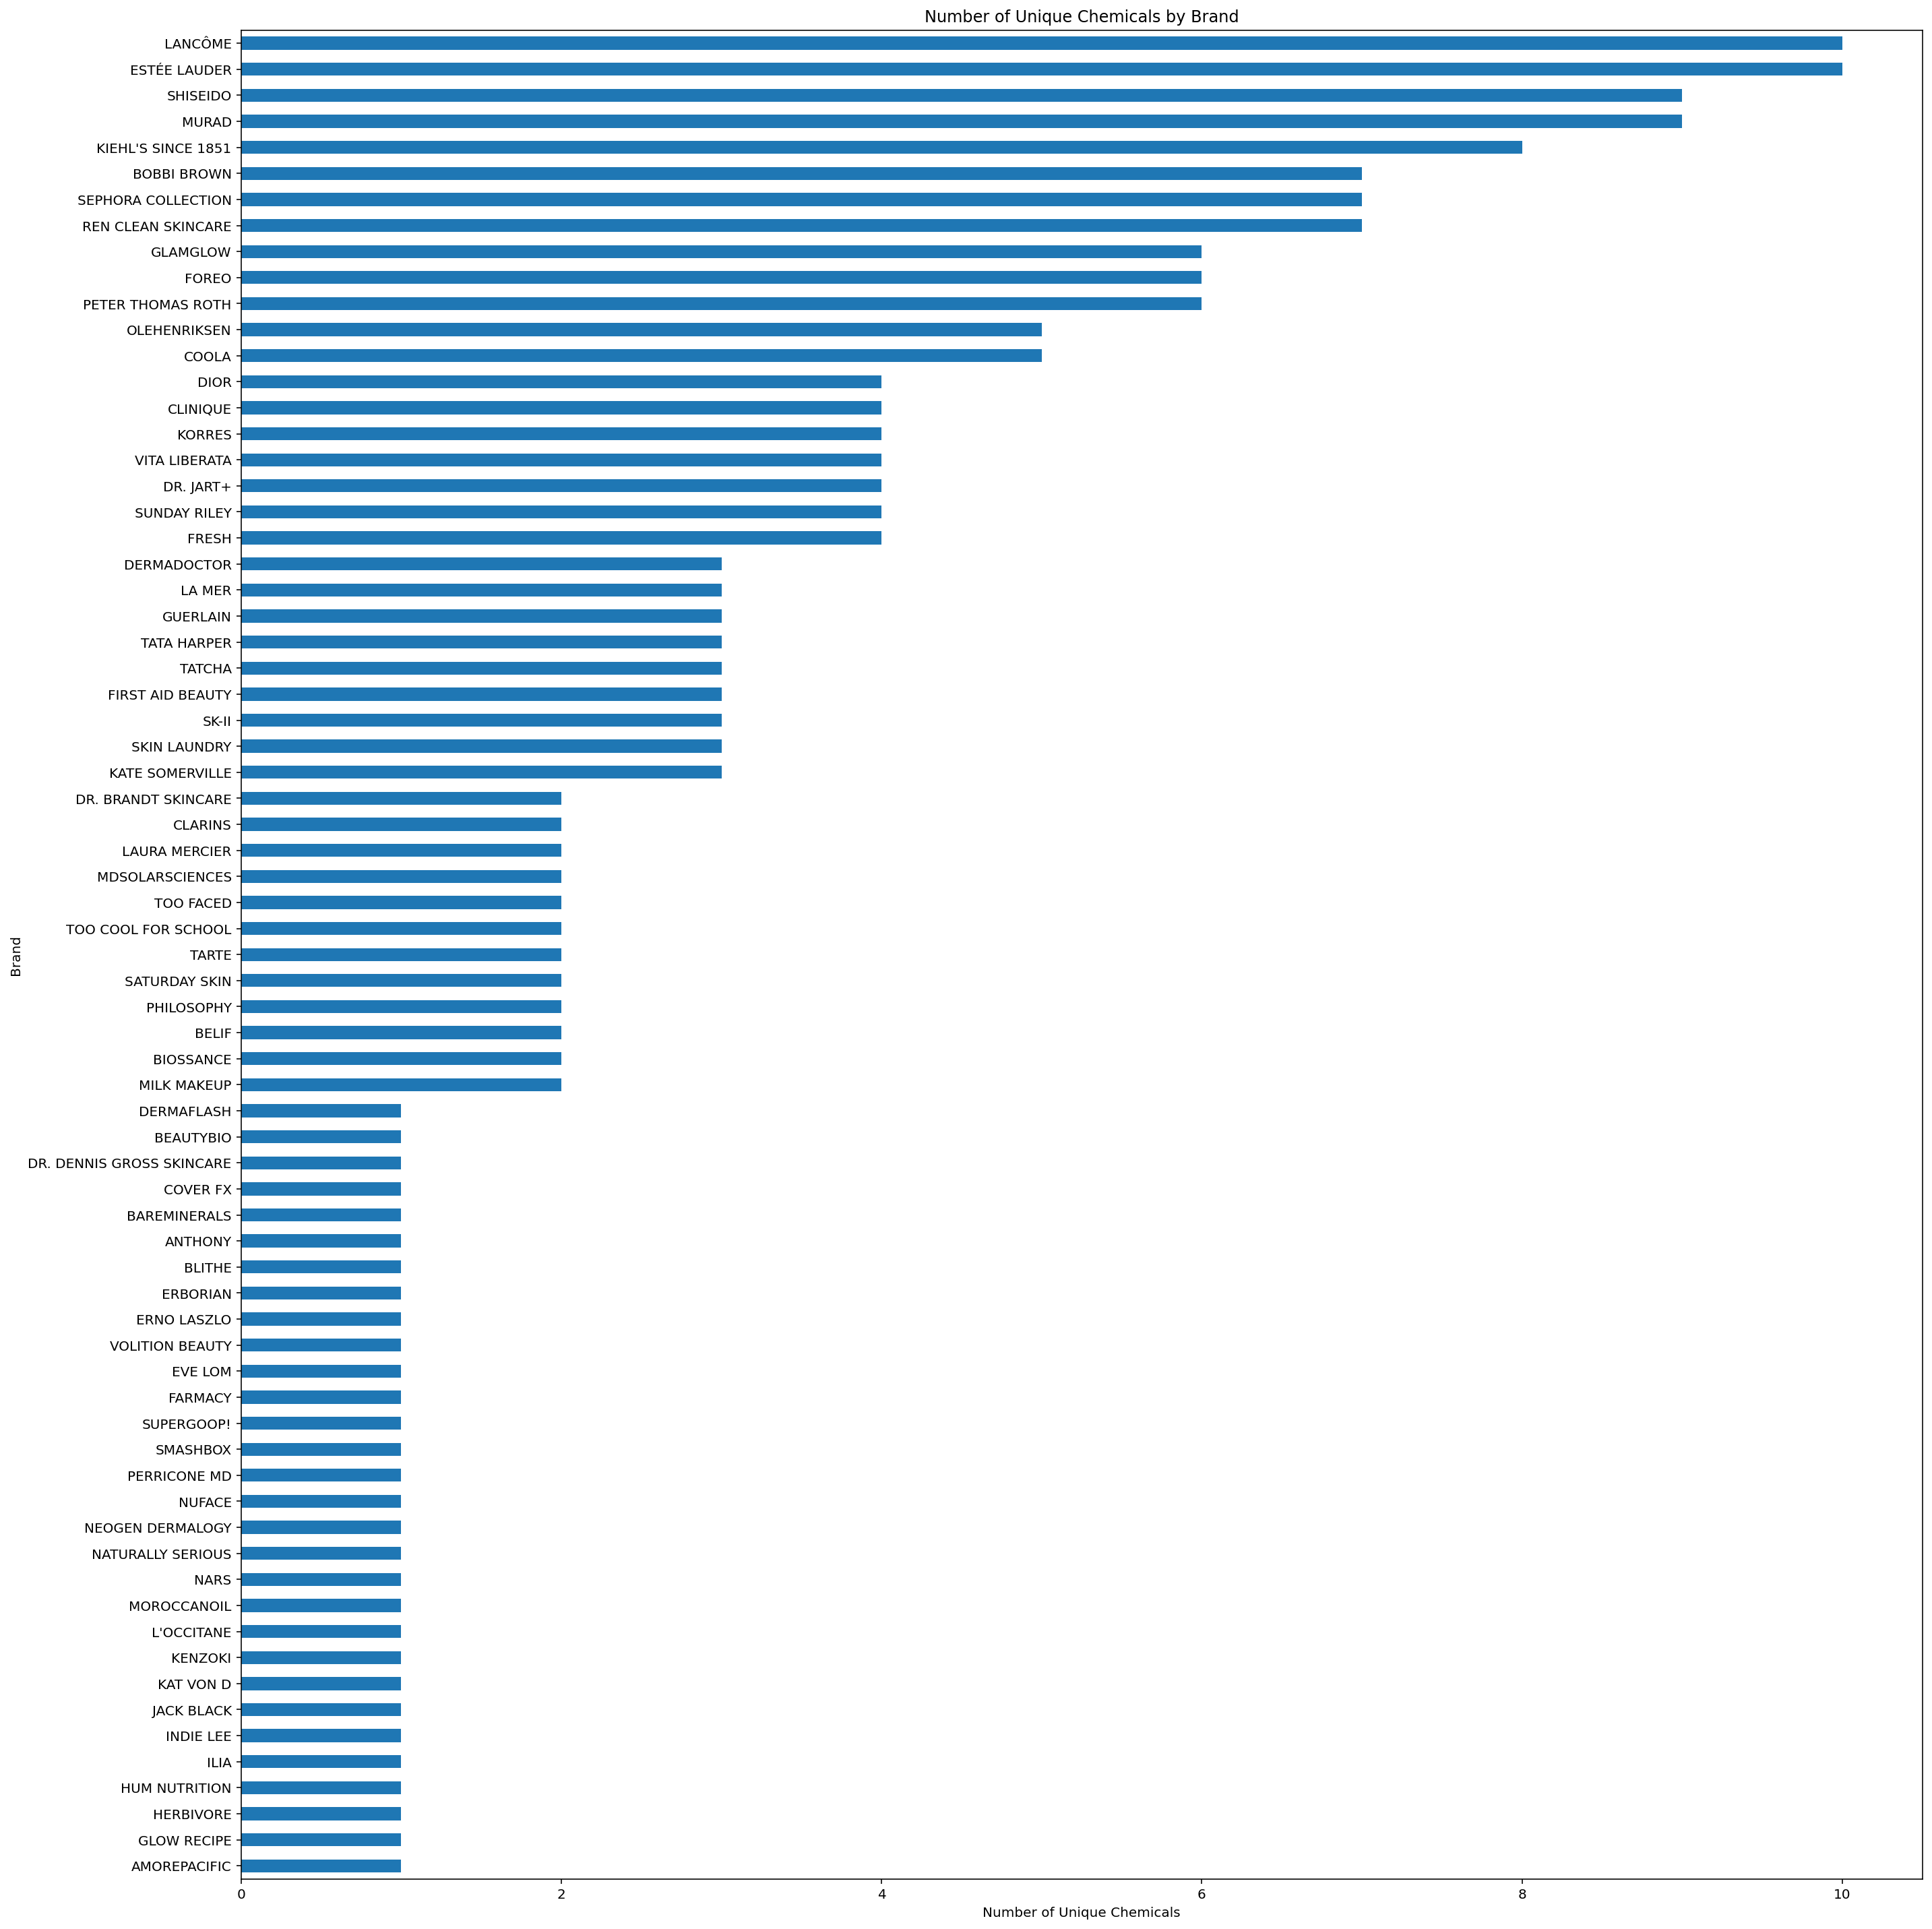

In [81]:
# number of unique chemicals per brand
chemicals_by_brand = balanced_df.groupby('brand')['ChemicalName'].nunique().sort_values()
plt.figure(figsize=(20, 20))
chemicals_by_brand.plot(kind='barh')
plt.xlabel('Number of Unique Chemicals')
plt.ylabel('Brand')
plt.title('Number of Unique Chemicals by Brand')
plt.tight_layout()
plt.show()

In [82]:
# pivot table to aggregate the binary values for each chemical and skin type combination
pivot_table = balanced_df.pivot_table(index='ChemicalName', 
                                values=['dry', 'normal', 'oily', 'sensitive'], 
                                aggfunc='sum')

<Figure size 1296x720 with 0 Axes>

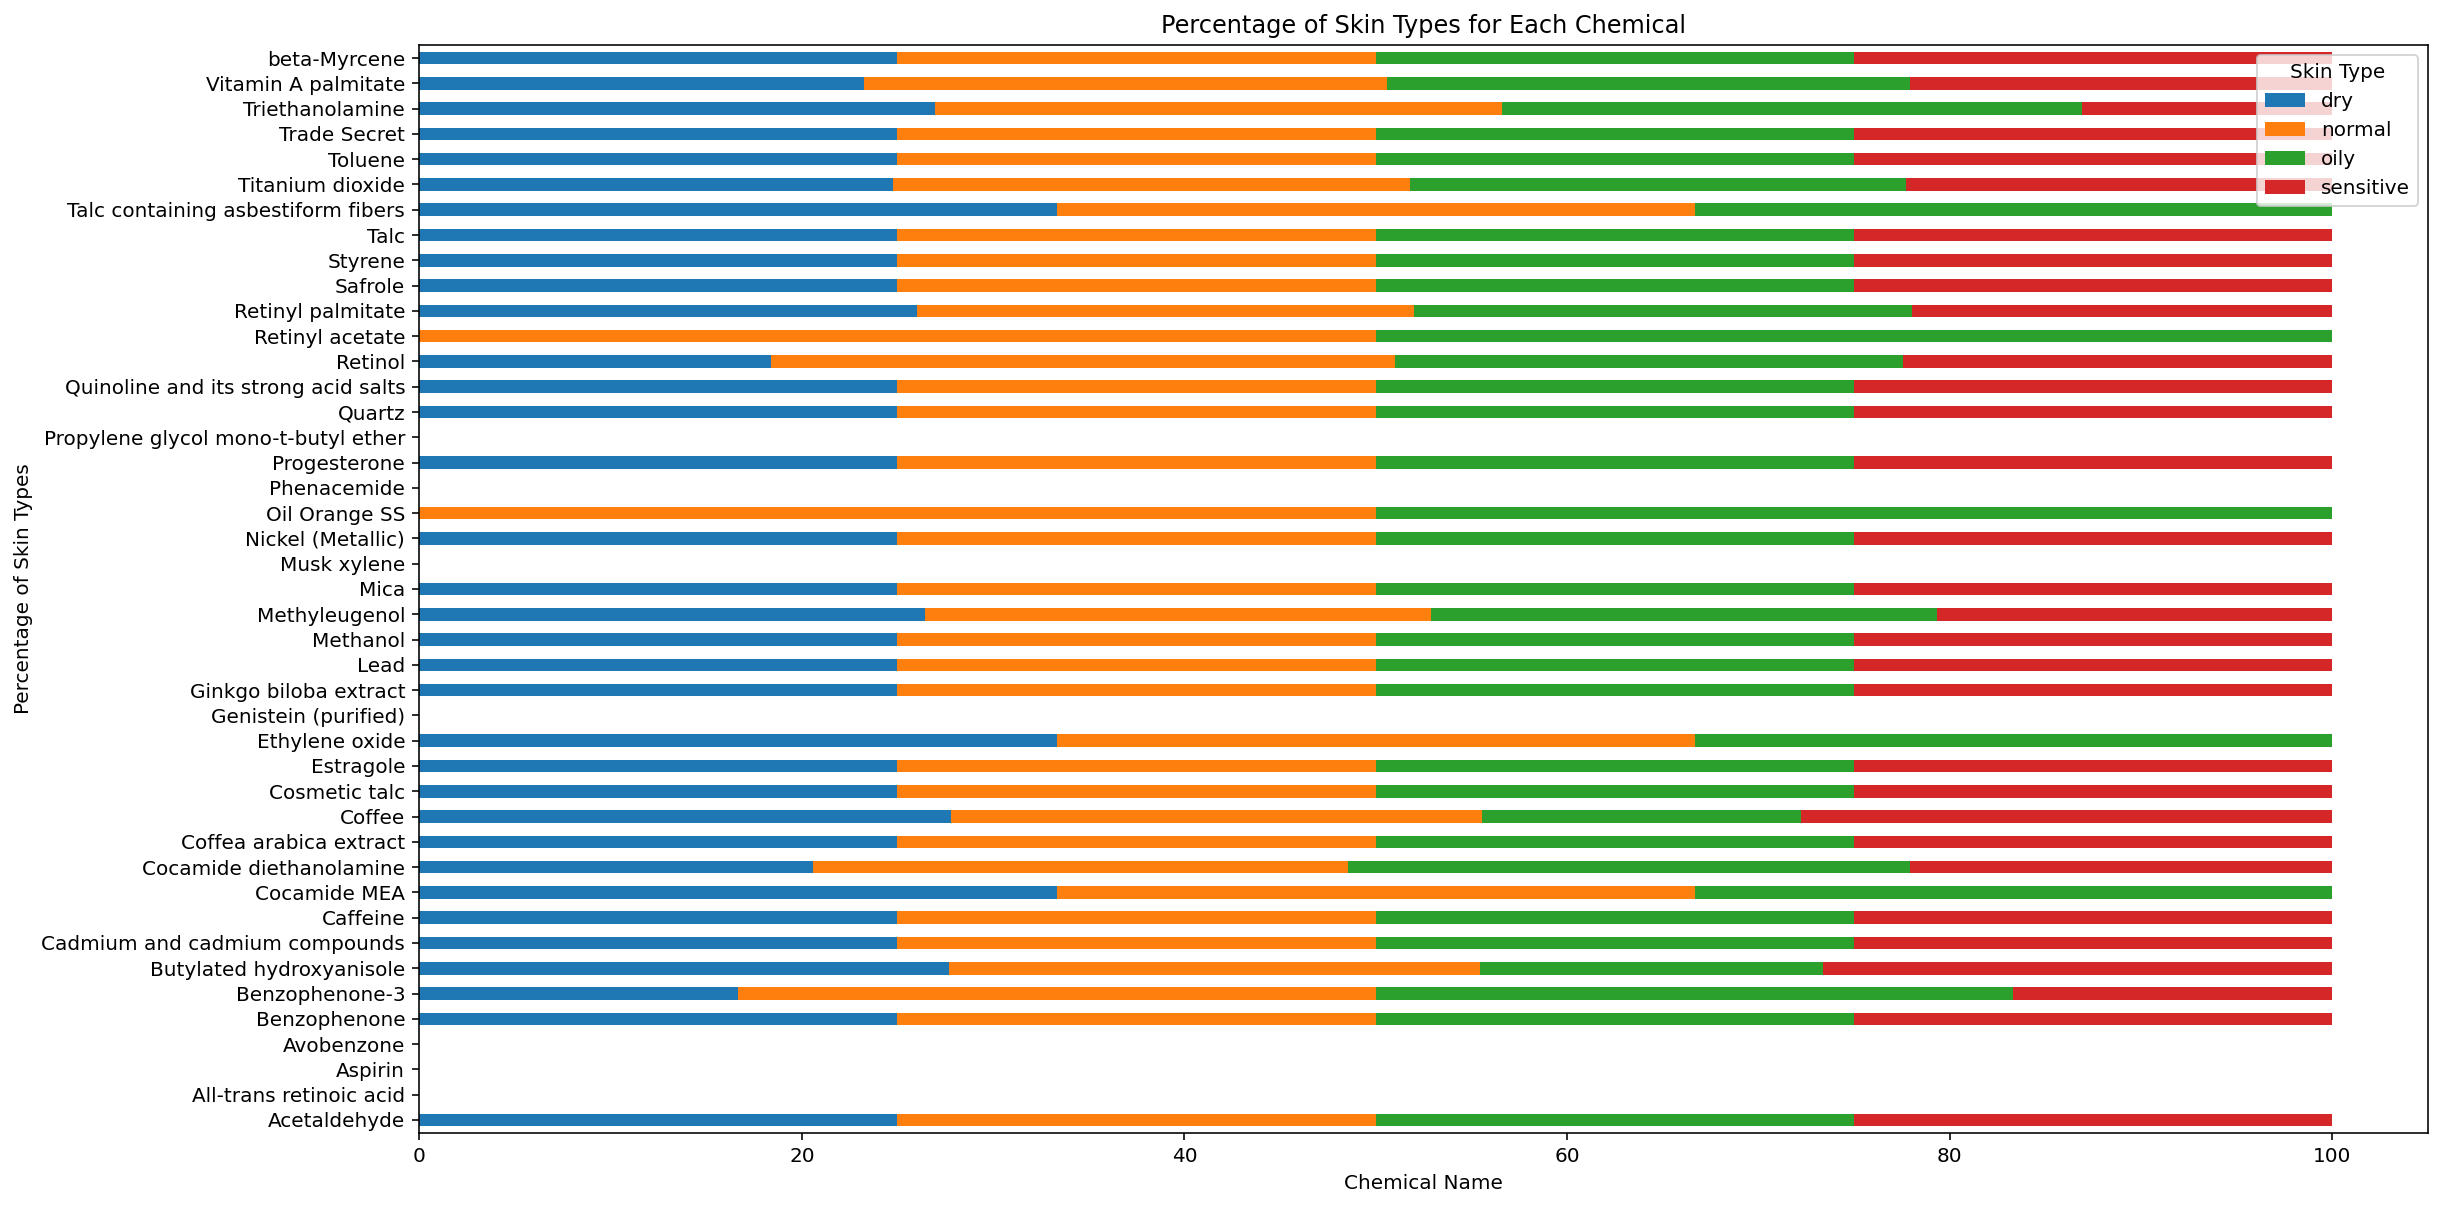

In [83]:
# calculate total number of chemicals per skin type
pivot_table['total'] = pivot_table.sum(axis=1)

# calculate percentage of each skin type for each chemical
for col in pivot_table.columns:
    pivot_table[col] = pivot_table[col] / pivot_table['total'] * 100
pivot_table.drop(columns='total', inplace=True)

# set figure size
plt.figure(figsize=(18, 10))

# plot % of skin types for each chemical 
pivot_table.plot(kind='barh', stacked=True, figsize=(18, 10))
plt.xlabel('Chemical Name')
plt.ylabel('Percentage of Skin Types')
plt.title('Percentage of Skin Types for Each Chemical')

plt.legend(title='Skin Type', loc='upper right')
plt.show();

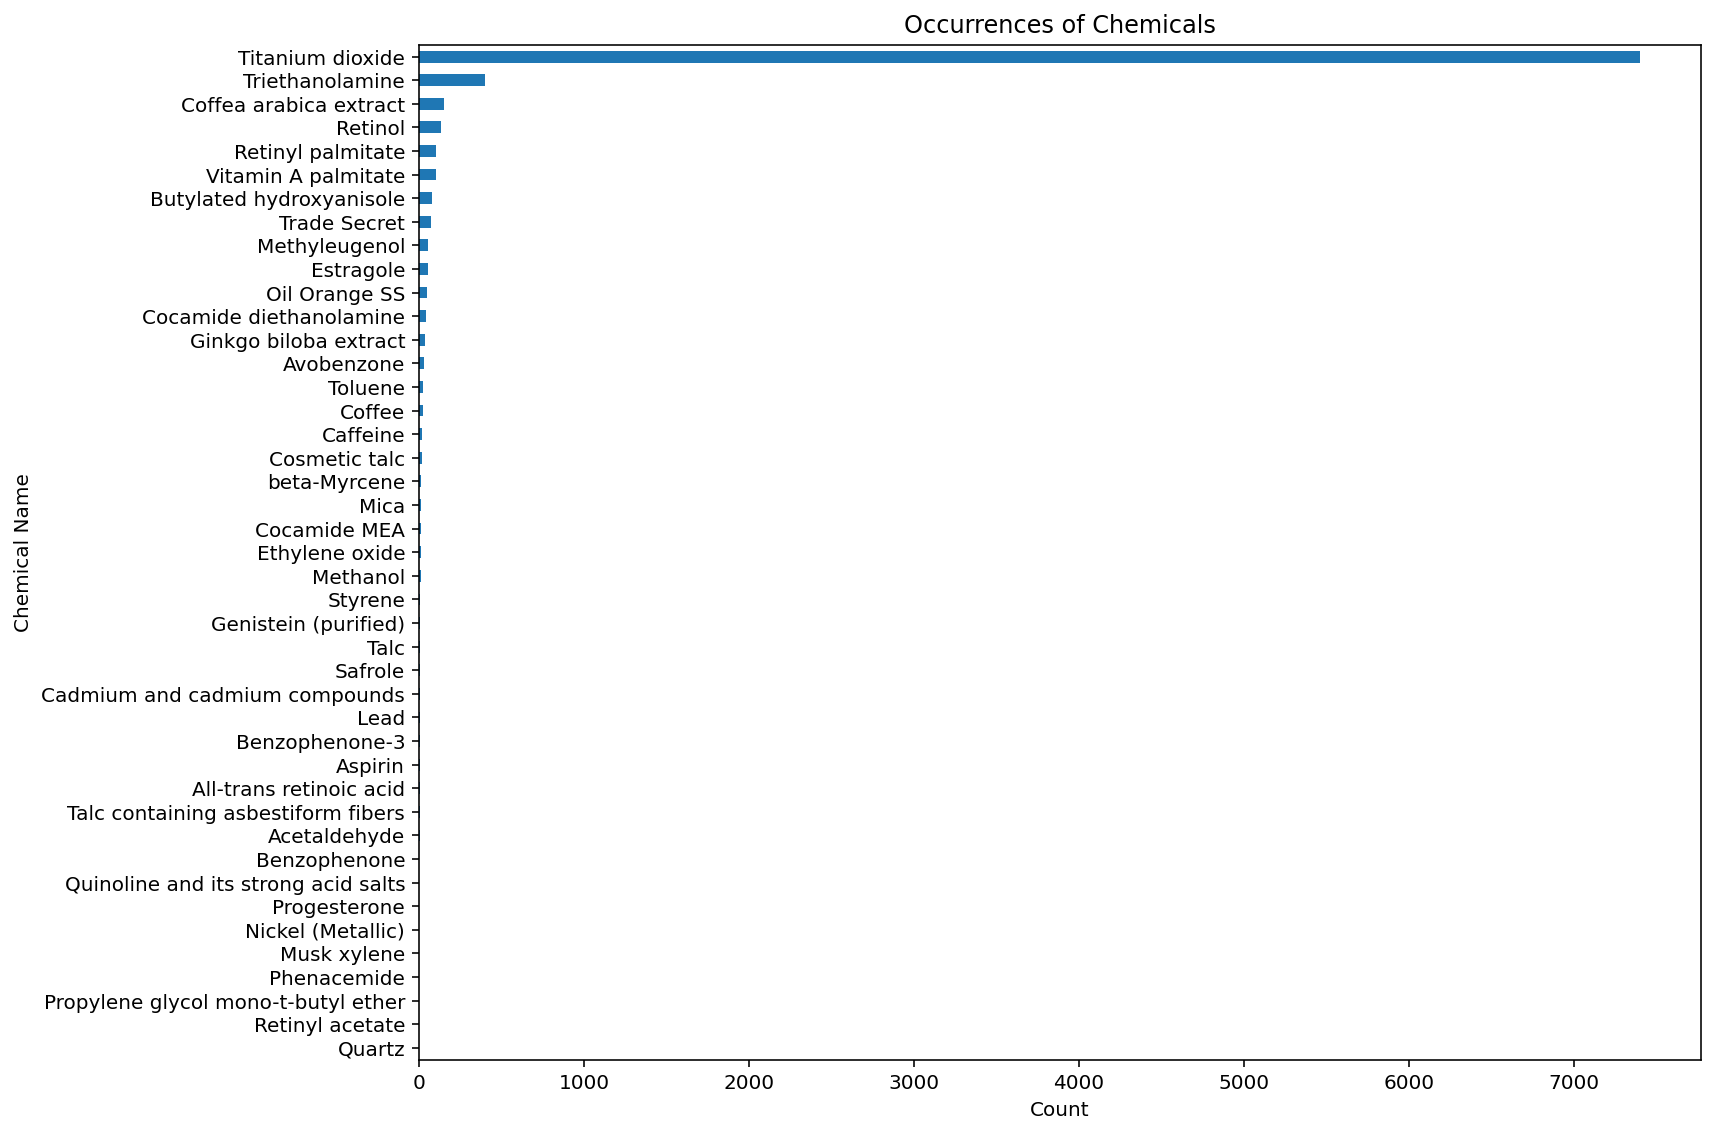

In [84]:
# Count occurrences of each chemical
chemical_counts = balanced_df['ChemicalName'].value_counts()
chemical_counts_sorted = chemical_counts.sort_values(ascending=True)

# Plot bar chart
plt.figure(figsize=(12, 8))
chemical_counts_sorted.plot(kind='barh')
plt.title('Occurrences of Chemicals')
plt.xlabel('Count')
plt.ylabel('Chemical Name')
plt.tight_layout()
plt.show()

In [85]:
# summary statistics of target column 'ordered'
balanced_df['ordered'].describe()

count    8906.000000
mean        0.449472
std         0.497468
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: ordered, dtype: float64

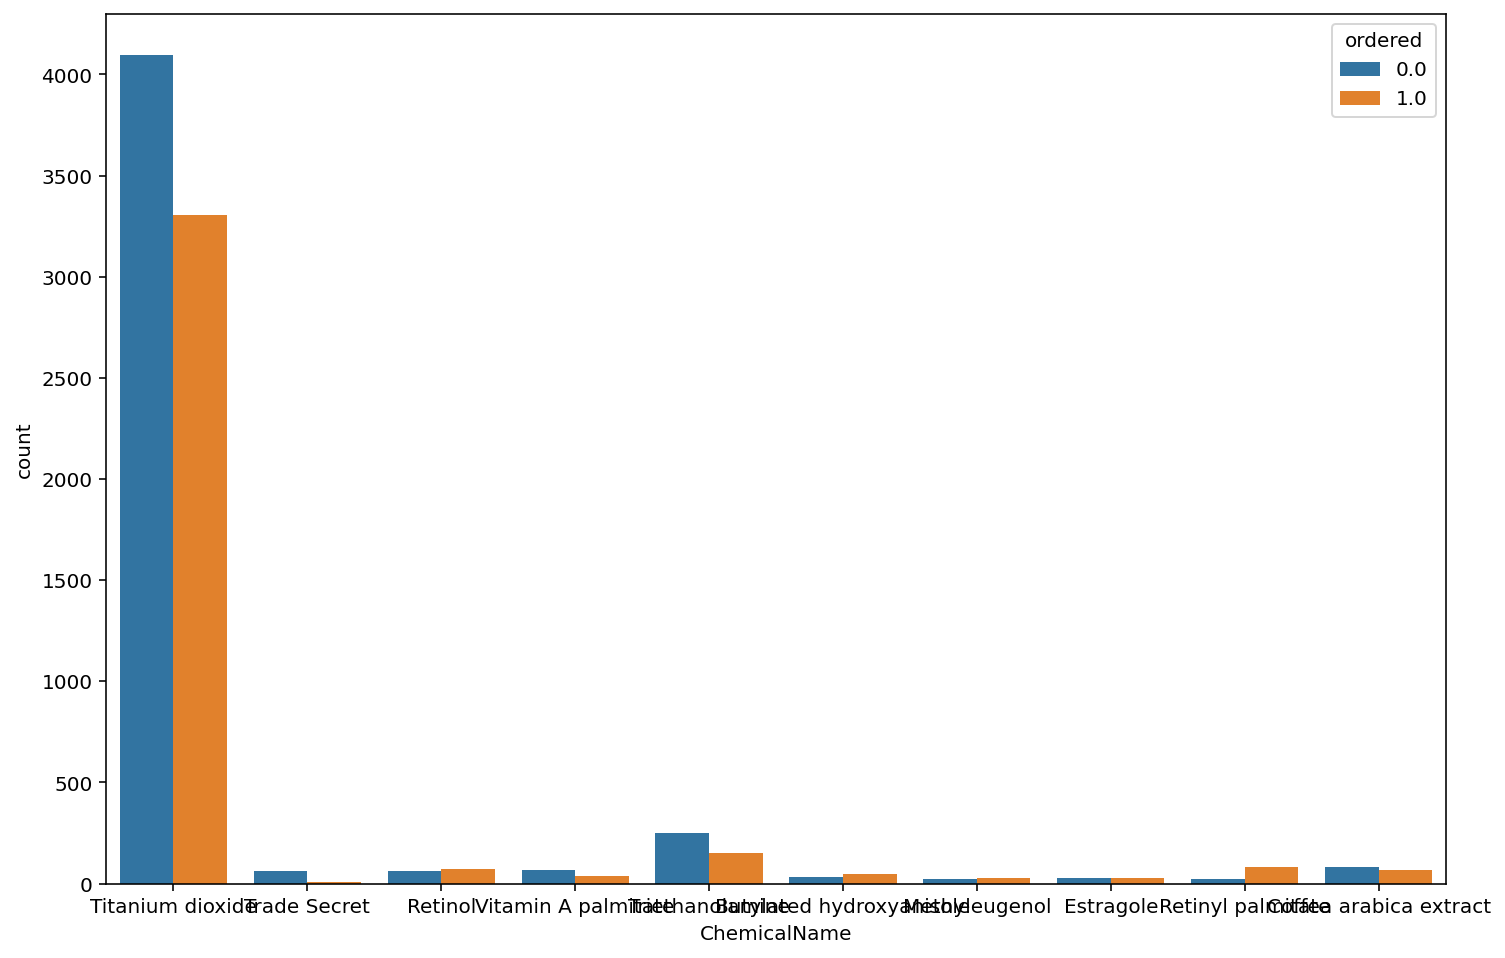

In [86]:
# create df for top chemicals + whether they were bought 
top_n_chemicals = balanced_df['ChemicalName'].value_counts().nlargest(10).index
top_n_df = balanced_df[balanced_df['ChemicalName'].isin(top_n_chemicals)]

# set figure
plt.figure(figsize=(12, 8))
sns.countplot(data=top_n_df, x="ChemicalName", hue="ordered")
plt.show()

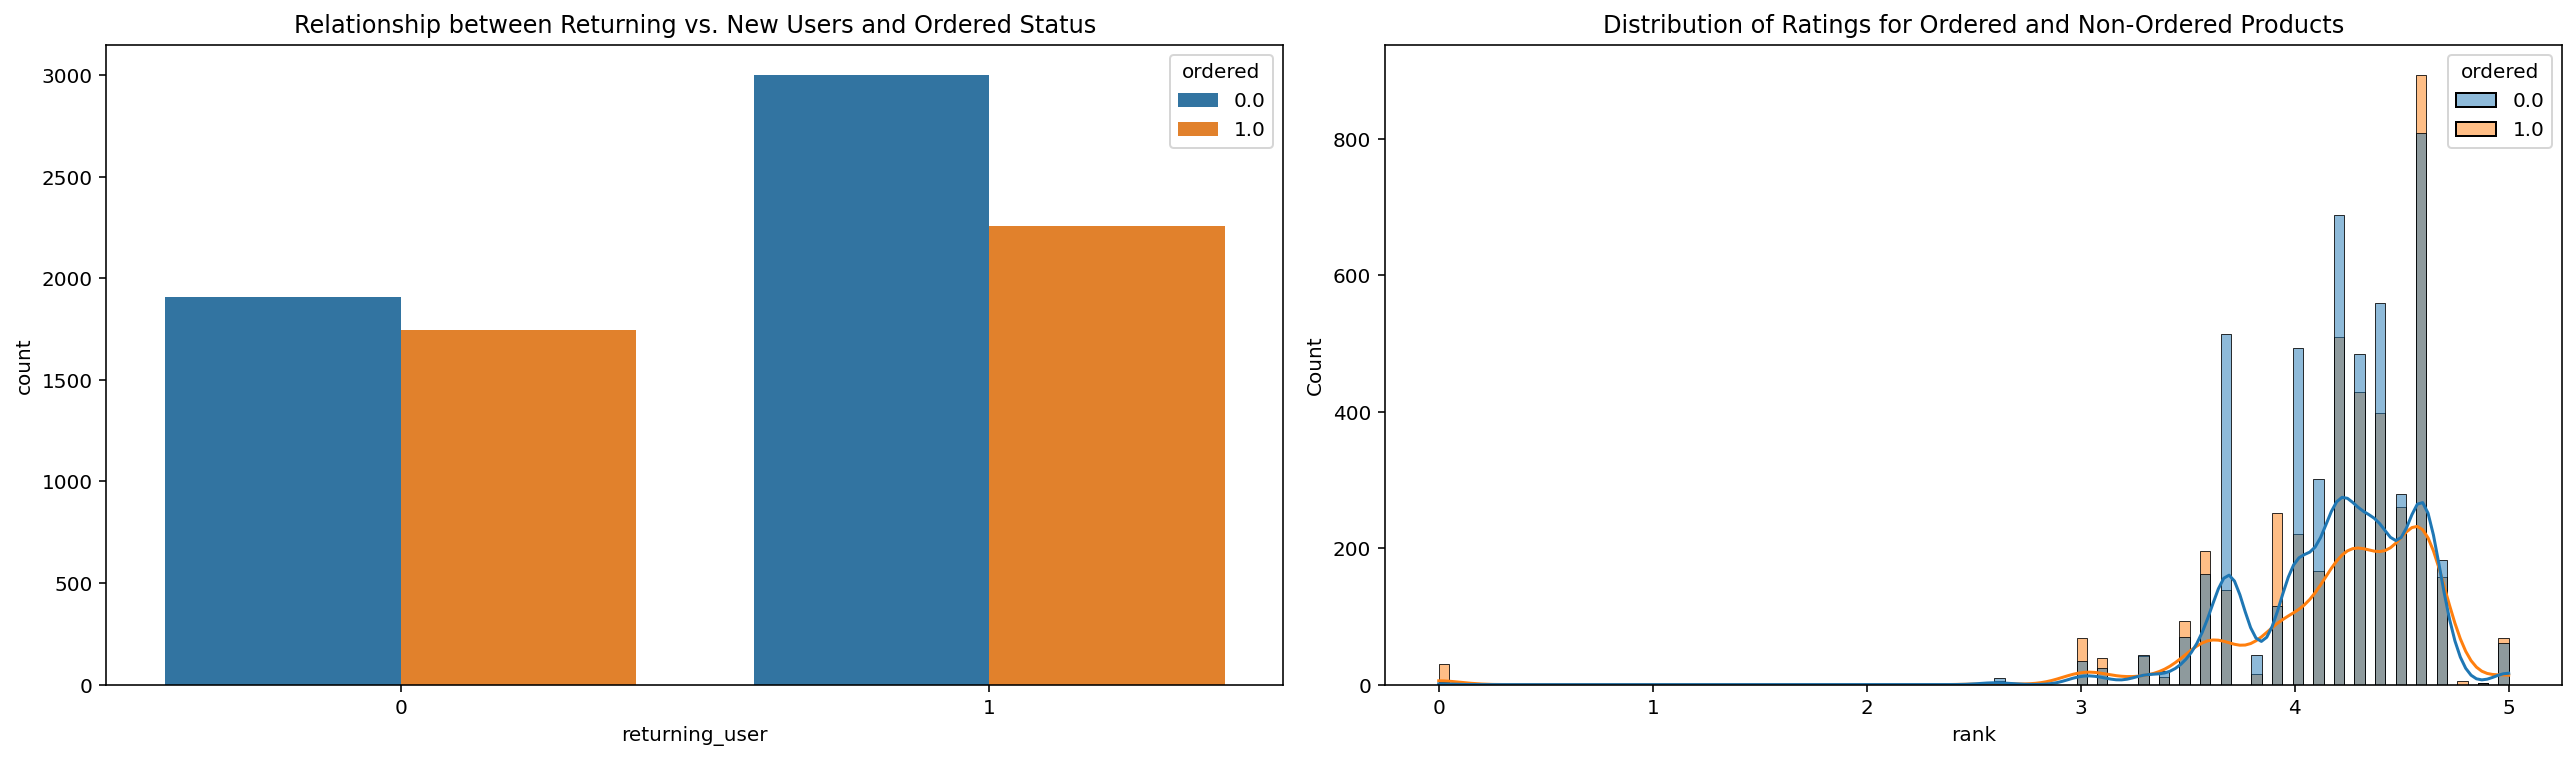

In [87]:
plt.figure(figsize=(18, 10))

# relationship between returning vs. new users and ordered status
plt.subplot(2, 2, 1)
sns.countplot(data=balanced_df, x='returning_user', hue='ordered')
plt.title('Relationship between Returning vs. New Users and Ordered Status')

# distribution of ratings for ordered and non-ordered products
plt.subplot(2, 2, 2)
sns.histplot(data=balanced_df, x='rank', hue='ordered', kde=True)
plt.title('Distribution of Ratings for Ordered and Non-Ordered Products')

plt.tight_layout()
plt.show()

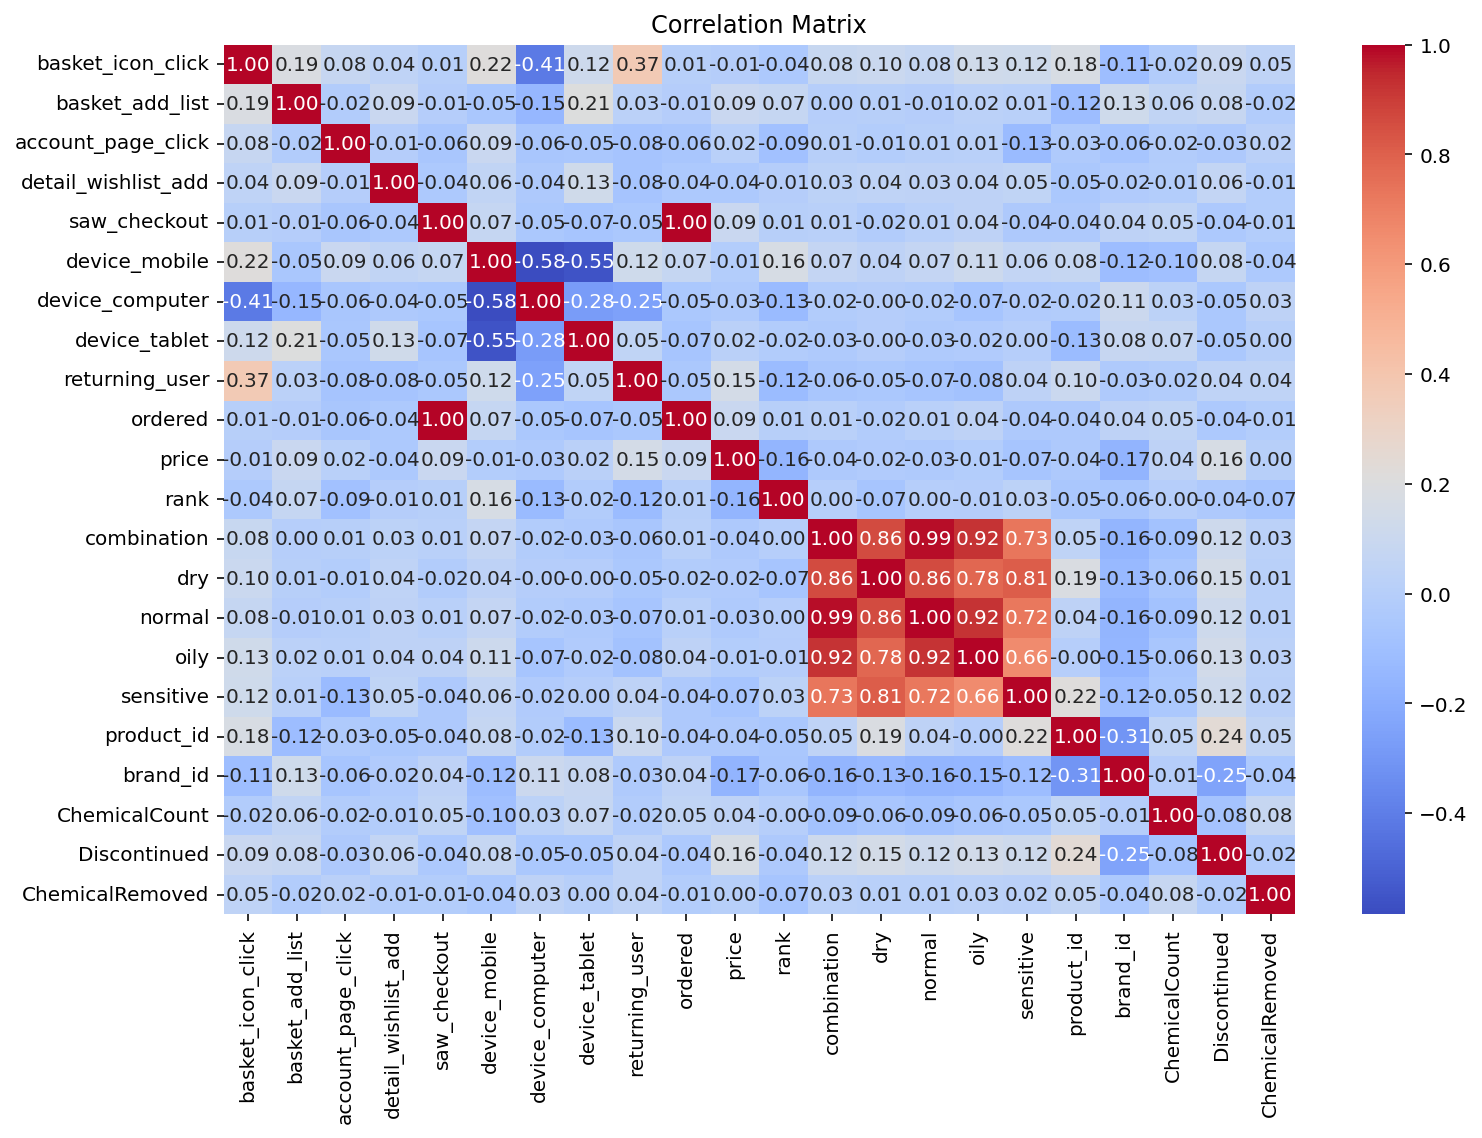

In [88]:
correlation_matrix = balanced_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()